In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [46]:
daily_df = pd.read_csv('usd_inr_daily_raw.csv', index_col=0, parse_dates=True)

In [47]:
daily_df

USD_INR  daily_diff
Date                             
2015-10-27  64.901001         NaN
2015-10-28  65.067001   64.901001
2015-10-29  64.945999   65.067001
2015-10-30  65.444000   64.945999
2015-11-02  65.415001   65.444000
...               ...         ...
2025-10-20  88.002296   87.990700
2025-10-21  87.879997   88.002296
2025-10-22  88.001602   87.879997
2025-10-23  87.740303   88.001602
2025-10-24  87.778999   87.740303

[2603 rows x 2 columns]

additional notes::

Stationarity Basics

A stationary series has:
- Constant mean over time
- Constant variance over time
- No strong trends or seasonal patterns

adf test
- H0 (null): The series has a unit root → NON-STATIONARY
- H1 (alternative): The series is stationary

Interpretation:

Value	Meaning
p-value ≤ 0.05	Reject H0 → Series is stationary
p-value > 0.05	Fail to reject H0 → Series is non-stationary

results:

- Original series: p-value = 0.936 → Fail to reject H0 → Non-stationary
- First difference: p-value ≈ 0 → Reject H0 → Stationary

This is typical for financial time series. Daily exchange rates usually need differencing to remove trends.


KPSS Test
KPSS = Kwiatkowski-Phillips-Schmidt-Shin test
How it works (intuition)
- KPSS decomposes a time series into three components:
    -  Deterministic trend (constant or linear)
    - Random walk (non-stationary component)
    - Stationary error
It measures the variance of the random walk component.
- Large variance → series is non-stationary
- Small variance → series is stationary
Hypotheses:
- H0 (null): Series is stationary
- H1 (alternative): Series is non-stationary

Notice this is opposite to ADF.

Interpretation:

Value	Meaning
p-value ≤ 0.05	Reject H0 → Series is non-stationary
p-value > 0.05	Fail to reject H0 → Series is stationary

results:

- Original series: p-value = 0.01 → Reject H0 → Non-stationary

- First difference: p-value = 0.1 → Fail to reject H0 → Stationary

Why use both ADF and KPSS?
- ADF is more sensitive to unit roots
- KPSS is more sensitive to trend stationarity
- Using both together gives a more robust check

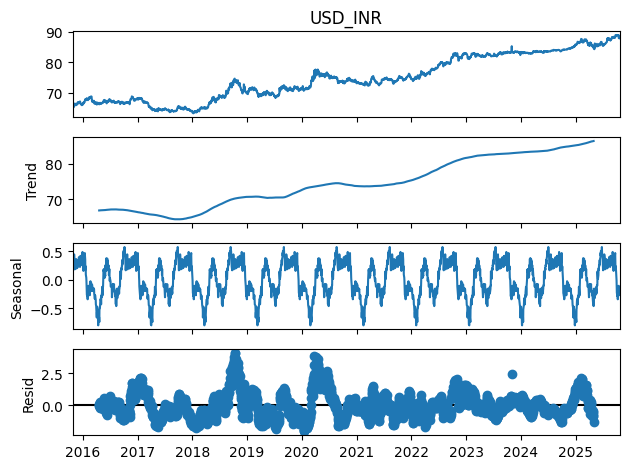

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(daily_df['USD_INR'], model='additive', period=252)
result.plot()
plt.show()
result_diff = adfuller(daily_df['USD_INR'].diff().dropna())



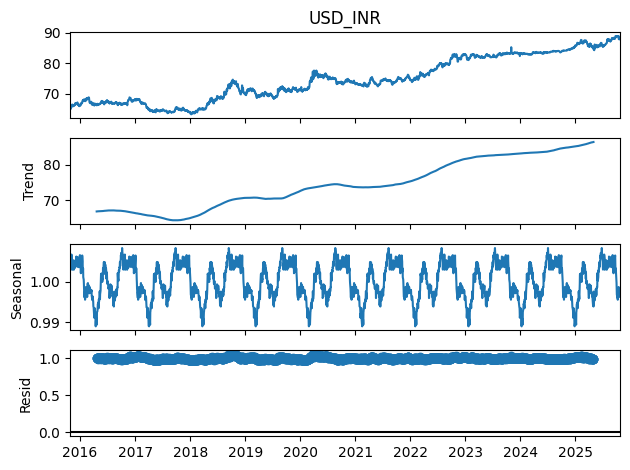

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

resulta = seasonal_decompose(daily_df['USD_INR'], model='multiplicative', period=252)
resulta.plot()
plt.show()
result_diff = adfuller(daily_df['USD_INR'].diff().dropna())



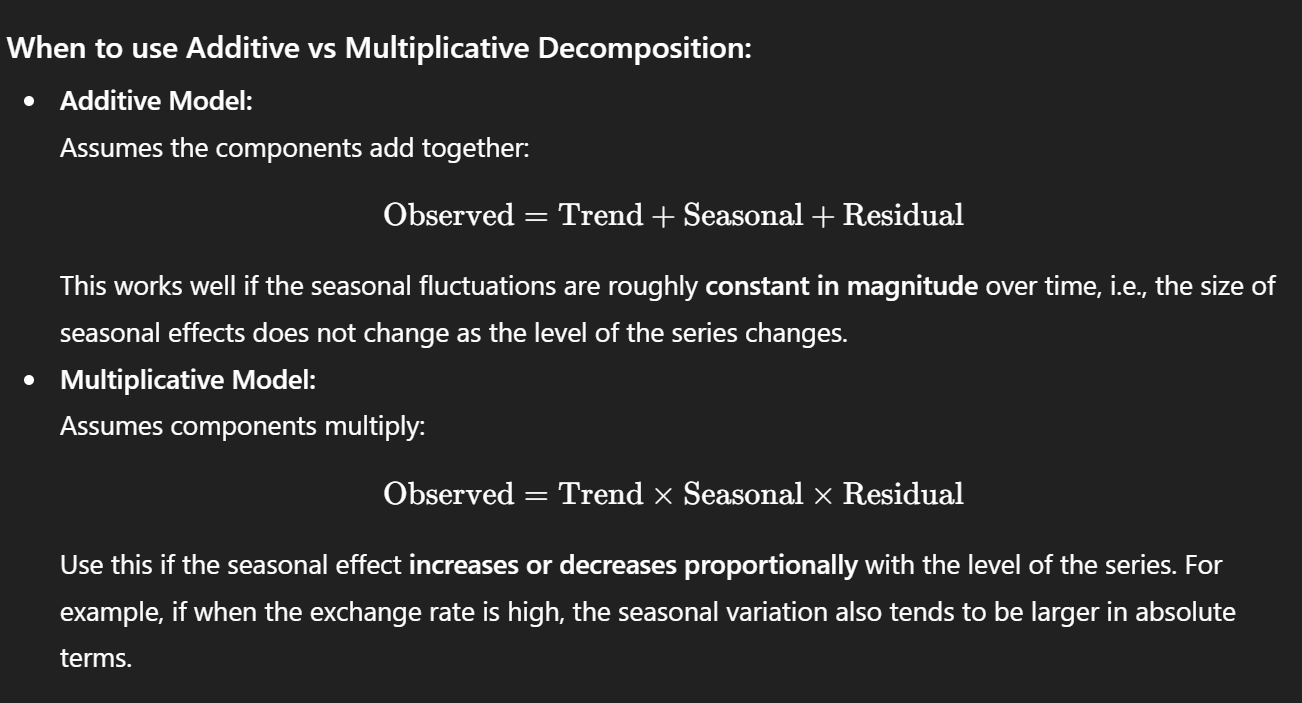

In currency exchange rates, seasonal effects are often additive, because fluctuations are more related to events or cycles that cause roughly similar absolute changes rather than proportional changes.

trend is increasing over time, but the seasonality remains roughly the same in terms of magnitude (the fluctuations don’t grow or shrink significantly as time progresses).

residuals appear to have a high variance, meaning that there are large, irregular fluctuations after the seasonal and trend components are removed.

Based on  graphs:
Use the additive model.
seasonal and residual amplitudes stay roughly constant despite the upward trend in USD/INR.

Multiplicative makes everything flat — a strong indicator it’s not suitable


Seasonal fluctuations ≈ constant magnitude	Additive
Seasonal fluctuations grow/shrink with level	Multiplicative

ACF

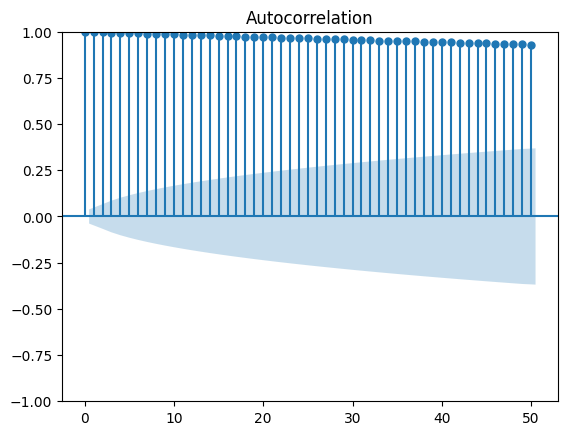

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(daily_df['USD_INR'].dropna(), lags=50)
plt.show()


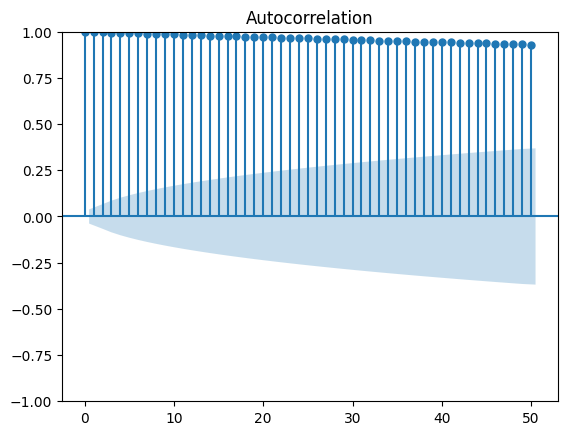

In [57]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(daily_df['daily_diff'].dropna(), lags=50)
plt.show()


The Autocorrelation Function (ACF) measures how much the current value of a time series is related to its past values (lags).

ACF shows how correlated  time series is with itself at previous time steps.

Key Observation:
The ACF plot shows a gradual decline in correlation as the lag increases, with significant positive autocorrelation at several lags.
The persistence of significant correlations at multiple lags suggests there might be a MA (Moving Average) component in the data.

Interpretation:

The behavior of the ACF suggests that the data could have MA(q) components, as the autocorrelation function is extended across multiple lags, but the correlation starts to decay after a certain point.

PACF

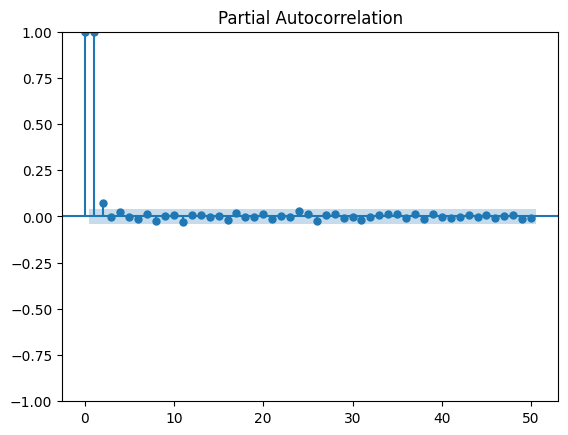

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(daily_df['USD_INR'].dropna(), lags=50)
plt.show()

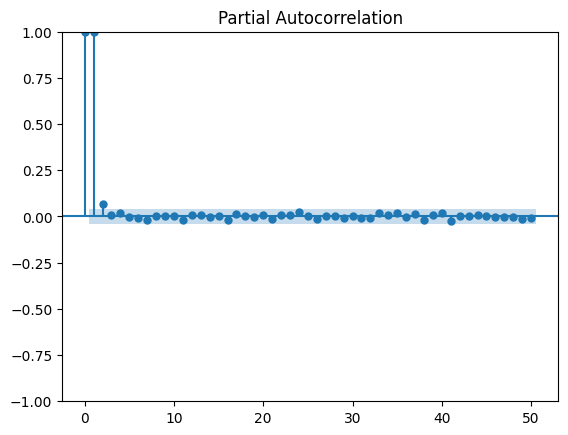

In [58]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(daily_df['daily_diff'].dropna(), lags=50)
plt.show()


PACF (Partial Autocorrelation Function) measures the direct correlation between a time series and its lagged versions, after removing the effects of all the intermediate lags.

The PACF plot shows how today’s value is related to past values directly, not indirectly through other lags.
inference
The PACF plot shows a sharp spike at lag 1, followed by values that remain near zero for the rest of the lags.

This suggests that there is significant autocorrelation at lag 1, and after that, the time series is not strongly influenced by previous values.

Interpretation:

The PACF suggests that  time series data could potentially have an AR(1) (Autoregressive) component, as the first lag is significant and higher-order lags are not.

In AR models, only the most recent observation impacts the forecast, which aligns with the PACF behavior here.

How PACF is used in forecasting:

When fitting an ARIMA model:

PACF helps identify the order of the AR (autoregressive) part → the parameter 𝑝

ACF helps identify the order of the MA (moving average) part → the parameter 
𝑞

ACF drops off around lag 2

PACF drops off after lag 1

d=1 - differencing

In [37]:
def train_test_split_ts(data, train_ratio=0.8):
    """Time series train-test split"""
    split_idx = int(len(data) * train_ratio)
    train = data[:split_idx]
    test = data[split_idx:]
    return train, test

def evaluate_forecast(actual, predicted, model_name):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    
    # Directional accuracy
    actual_direction = np.diff(actual) > 0
    pred_direction = np.diff(predicted) > 0
    directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  MAPE: {mape:.4f}%")
    print(f"  Directional Accuracy: {directional_accuracy:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'Dir_Acc': directional_accuracy}
def plot_forecast(train, test, forecast, title, filename):
    """Plot actual vs forecast"""
    plt.figure(figsize=(14, 6))
    plt.plot(train.index, train, label='Train', color='blue', linewidth=1)
    plt.plot(test.index, test, label='Test (Actual)', color='green', linewidth=2)
    plt.plot(test.index, forecast, label='Forecast', color='red', linewidth=2, linestyle='--')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('USD/INR Exchange Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: {filename}")
    plt.close()
    
# Split data
train_daily, test_daily = train_test_split_ts(daily_df['USD_INR'], train_ratio=0.8)

print(f"\nTrain: {len(train_daily)} days ({train_daily.index[0].date()} to {train_daily.index[-1].date()})")
print(f"Test:  {len(test_daily)} days ({test_daily.index[0].date()} to {test_daily.index[-1].date()})")



Train: 2082 days (2015-10-27 to 2023-10-23)
Test:  521 days (2023-10-24 to 2025-10-24)


In [ ]:
 #Model 1: ARIMA(1,1,1) - Simple baseline
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


try:
    model_arima_111 = ARIMA(train_daily, order=(1,1,1))
    fitted_arima_111 = model_arima_111.fit()
    
    print("\nModel Summary:")
    print(fitted_arima_111.summary())
    
    # Forecast
    forecast_arima_111 = fitted_arima_111.forecast(steps=len(test_daily))
    
    # Evaluate
    results_arima_111 = evaluate_forecast(test_daily.values, forecast_arima_111.values, "ARIMA(1,1,1)")
    
    # Plot
    plot_forecast(train_daily, test_daily, forecast_arima_111, 
                  'ARIMA(1,1,1) - Daily Forecast', '8_daily_arima_111.png')
    
except Exception as e:
    print(f"Error: {e}")
    results_arima_111 = None


[Model 1] ARIMA(1,1,1) - Daily

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                USD_INR   No. Observations:                 2082
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -288.794
Date:                Sun, 26 Oct 2025   AIC                            583.587
Time:                        21:23:08   BIC                            600.509
Sample:                             0   HQIC                           589.788
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1221      0.087      1.407      0.159      -0.048       0.292
ma.L1         -0.2818      0.085     -3.310      0.001      -0.449      -0.115
sigma

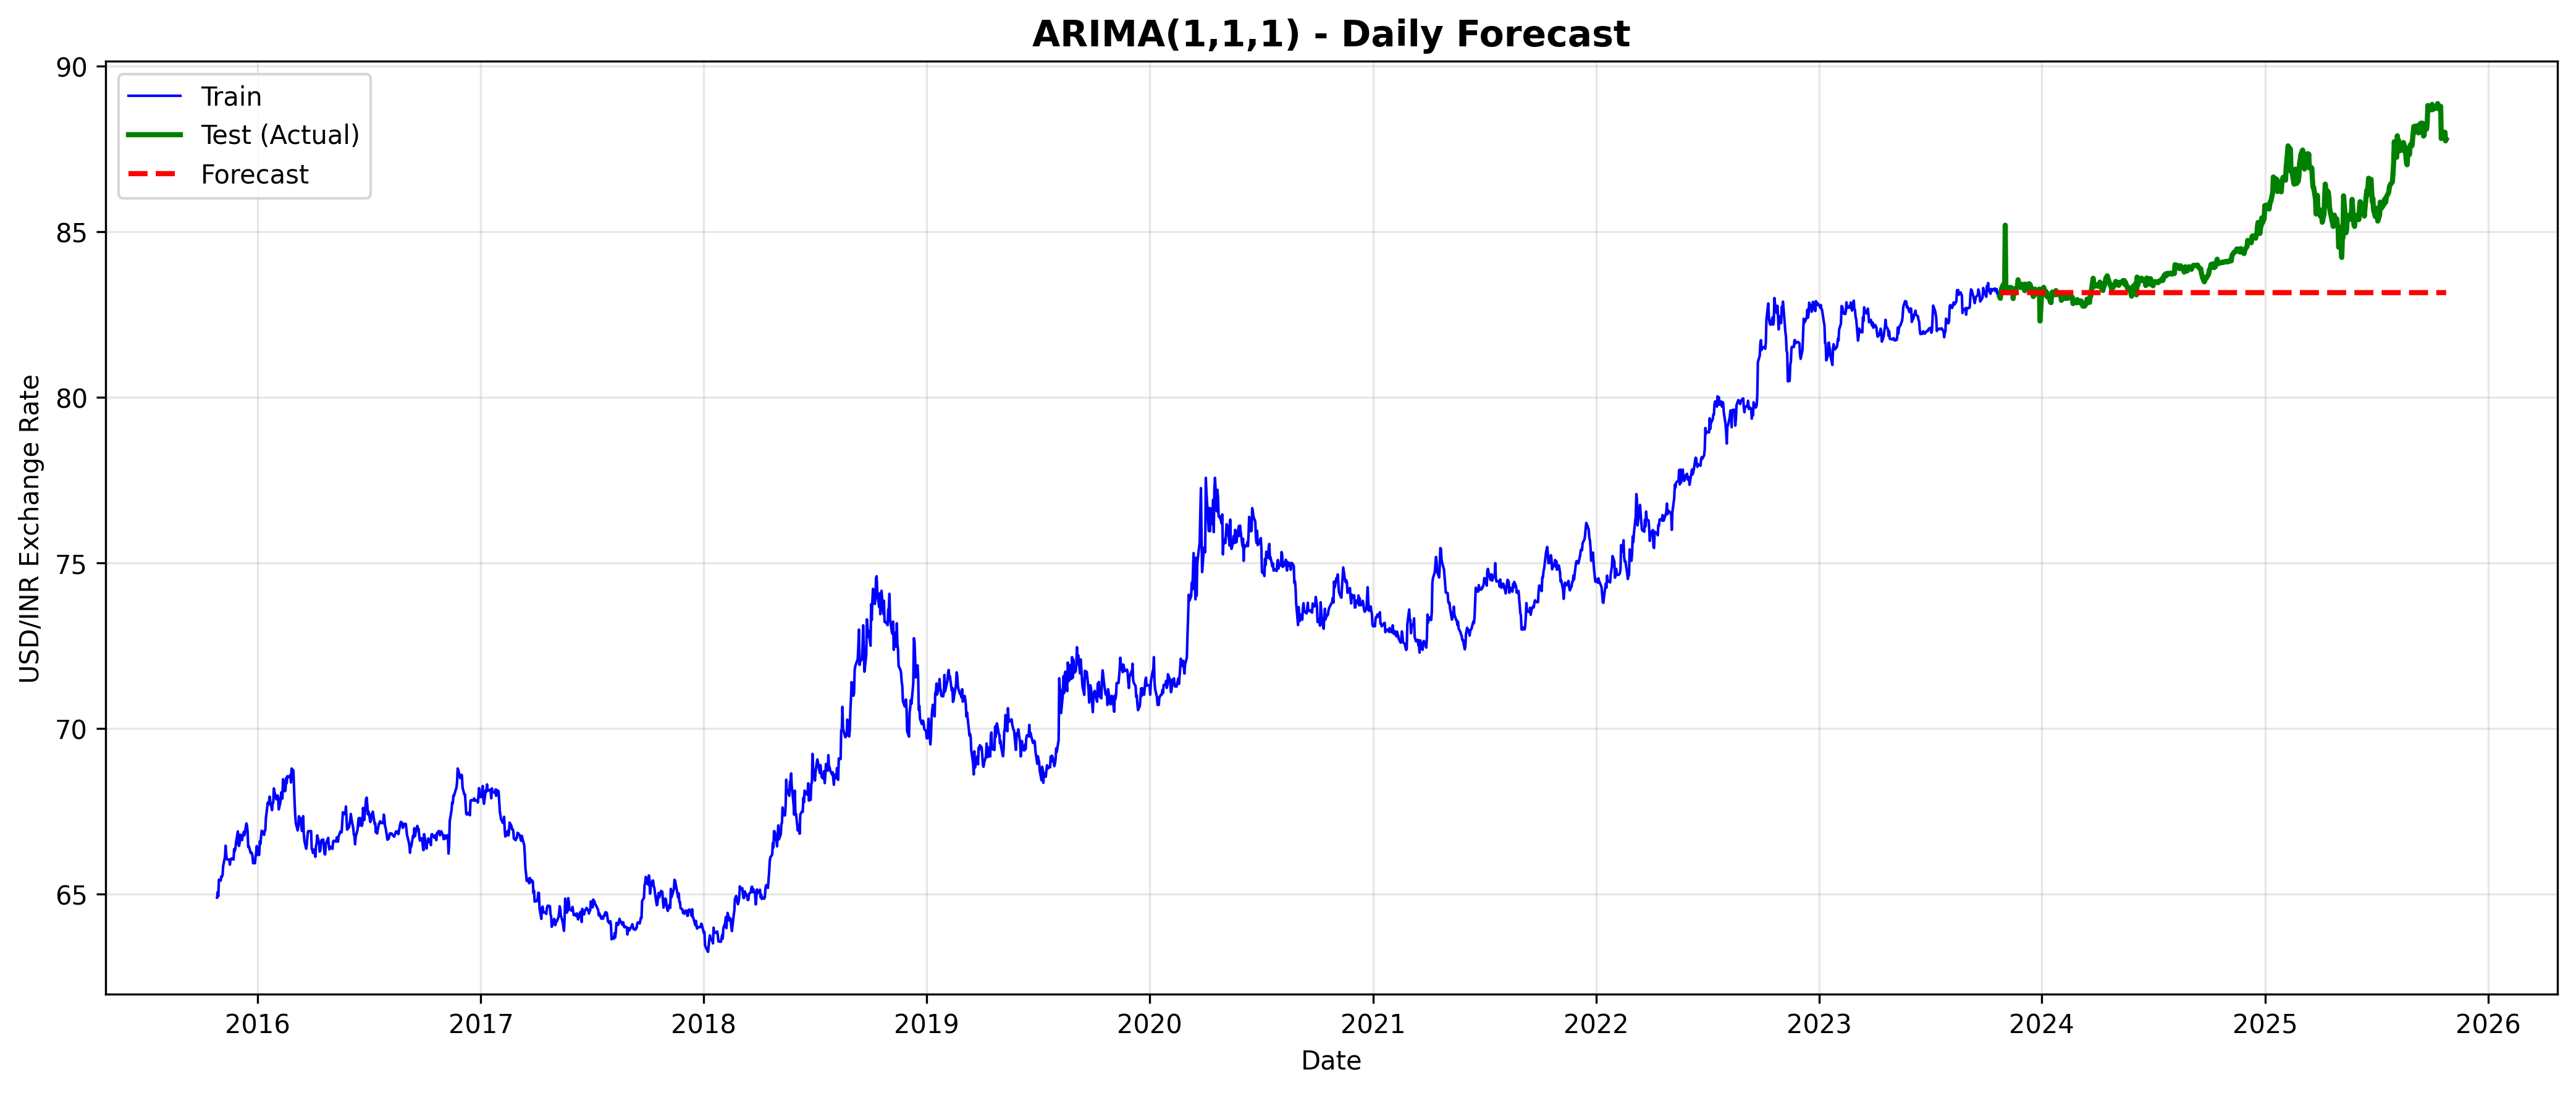


                               SARIMAX Results                                
Dep. Variable:                USD_INR   No. Observations:                 2603
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -301.987
Date:                Sun, 26 Oct 2025   AIC                            605.974
Time:                        21:35:16   BIC                            611.838
Sample:                             0   HQIC                           608.099
                               - 2603                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0738      0.001     75.717      0.000       0.072       0.076
Ljung-Box (L1) (Q):                  75.21   Jarque-Bera (JB):              5046.00
Prob(Q):                              0.00   Pr

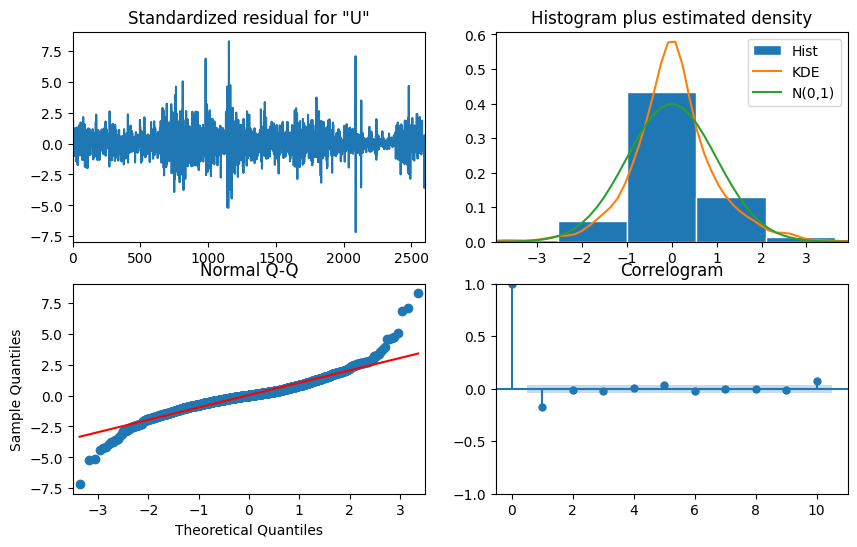

In [60]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(daily_df['USD_INR'], order=(0,1,0))
result = model.fit()
print(result.summary())


result.plot_diagnostics(figsize=(10,6))
plt.show()


                               SARIMAX Results                                
Dep. Variable:                USD_INR   No. Observations:                 2603
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -261.564
Date:                Sun, 26 Oct 2025   AIC                            529.129
Time:                        21:27:12   BIC                            546.721
Sample:                             0   HQIC                           535.502
                               - 2603                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1072      0.070      1.527      0.127      -0.030       0.245
ma.L1         -0.2838      0.069     -4.106      0.000      -0.419      -0.148
sigma2         0.0716      0.001     73.847      0.0

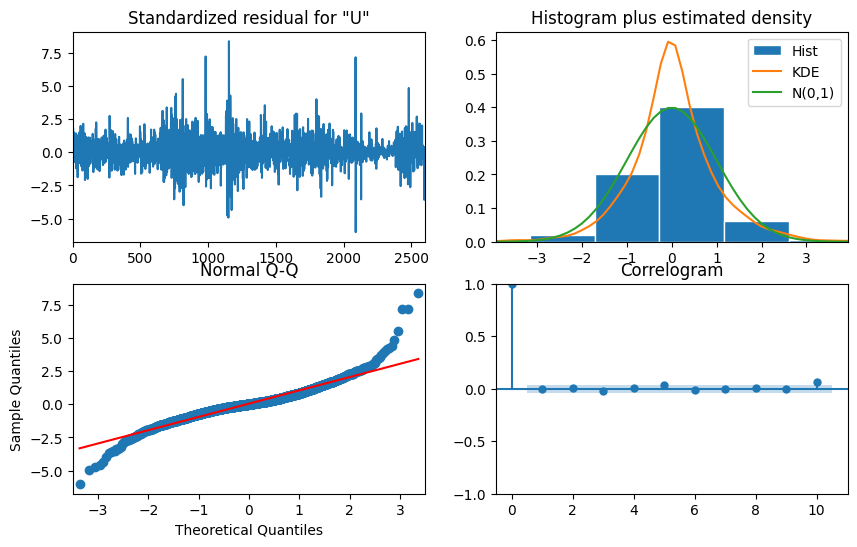

In [42]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(daily_df['USD_INR'], order=(1,1,1))
result = model.fit()
print(result.summary())


result.plot_diagnostics(figsize=(10,6))
plt.show()


                               SARIMAX Results                                
Dep. Variable:                USD_INR   No. Observations:                 2603
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -261.537
Date:                Sun, 26 Oct 2025   AIC                            531.074
Time:                        21:09:01   BIC                            554.530
Sample:                             0   HQIC                           539.573
                               - 2603                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2208      0.716      0.308      0.758      -1.183       1.625
ma.L1         -0.3975      0.716     -0.555      0.579      -1.801       1.006
ma.L2          0.0213      0.132      0.161      0.8

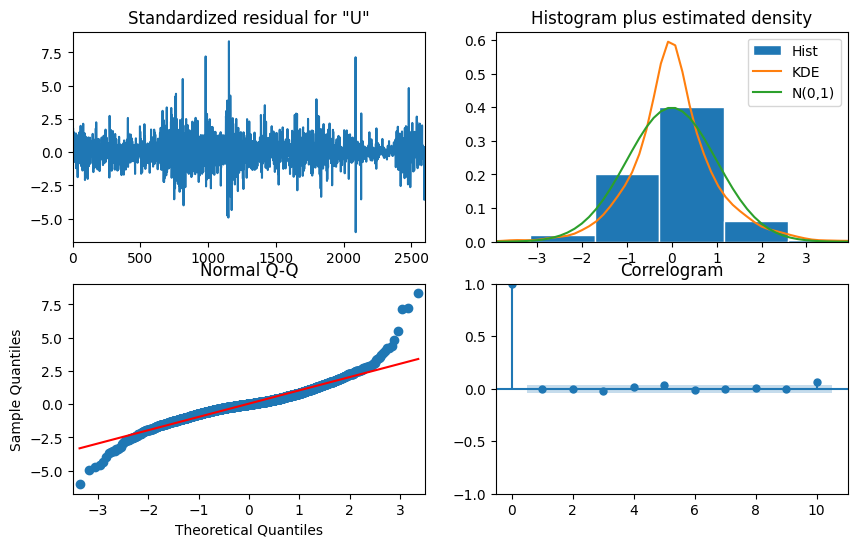

In [ ]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(daily_df['USD_INR'], order=(1,1,2))
result = model.fit()
print(result.summary())


result.plot_diagnostics(figsize=(10,6))
plt.show()


                               SARIMAX Results                                
Dep. Variable:                USD_INR   No. Observations:                 2603
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -261.340
Date:                Sun, 26 Oct 2025   AIC                            532.681
Time:                        21:27:26   BIC                            562.001
Sample:                             0   HQIC                           543.304
                               - 2603                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2091      1.060     -0.197      0.844      -2.286       1.868
ar.L2          0.0893      0.107      0.835      0.403      -0.120       0.299
ma.L1          0.0320      1.060      0.030      0.9

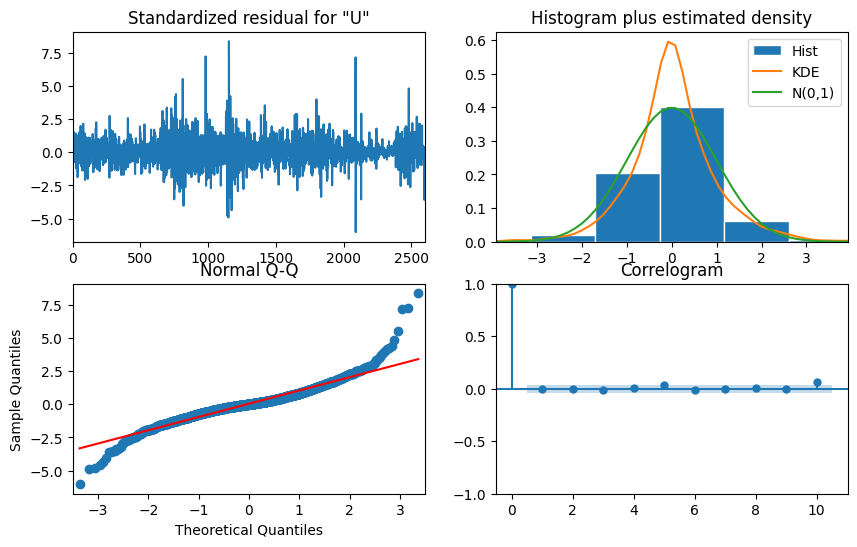

In [43]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(daily_df['USD_INR'], order=(2,1,2))
result = model.fit()
print(result.summary())


result.plot_diagnostics(figsize=(10,6))
plt.show()


In [40]:
# ============================================
# Model 2: ARIMA(2,1,2) - More complex
# ============================================
print("\n" + "─"*70)
print("[Model 2] ARIMA(2,1,2) - Daily")
print("─"*70)

try:
    model_arima_212 = ARIMA(train_daily, order=(2,1,2))
    fitted_arima_212 = model_arima_212.fit()
    
    print("\nAIC:", fitted_arima_212.aic)
    print("BIC:", fitted_arima_212.bic)
    
    # Forecast
    forecast_arima_212 = fitted_arima_212.forecast(steps=len(test_daily))
    
    # Evaluate
    results_arima_212 = evaluate_forecast(test_daily.values, forecast_arima_212.values, "ARIMA(2,1,2)")
    
    # Plot
    plot_forecast(train_daily, test_daily, forecast_arima_212, 
                  'ARIMA(2,1,2) - Daily Forecast', '9_daily_arima_212.png')
    
except Exception as e:
    print(f"Error: {e}")
    results_arima_212 = None


──────────────────────────────────────────────────────────────────────
[Model 2] ARIMA(2,1,2) - Daily
──────────────────────────────────────────────────────────────────────

AIC: 587.0554790081412
BIC: 615.2584981401094

ARIMA(2,1,2) Performance:
  RMSE: 2.396615
  MAE: 1.721936
  MAPE: 1.9915%
  Directional Accuracy: 47.12%
  ✓ Saved: 9_daily_arima_212.png


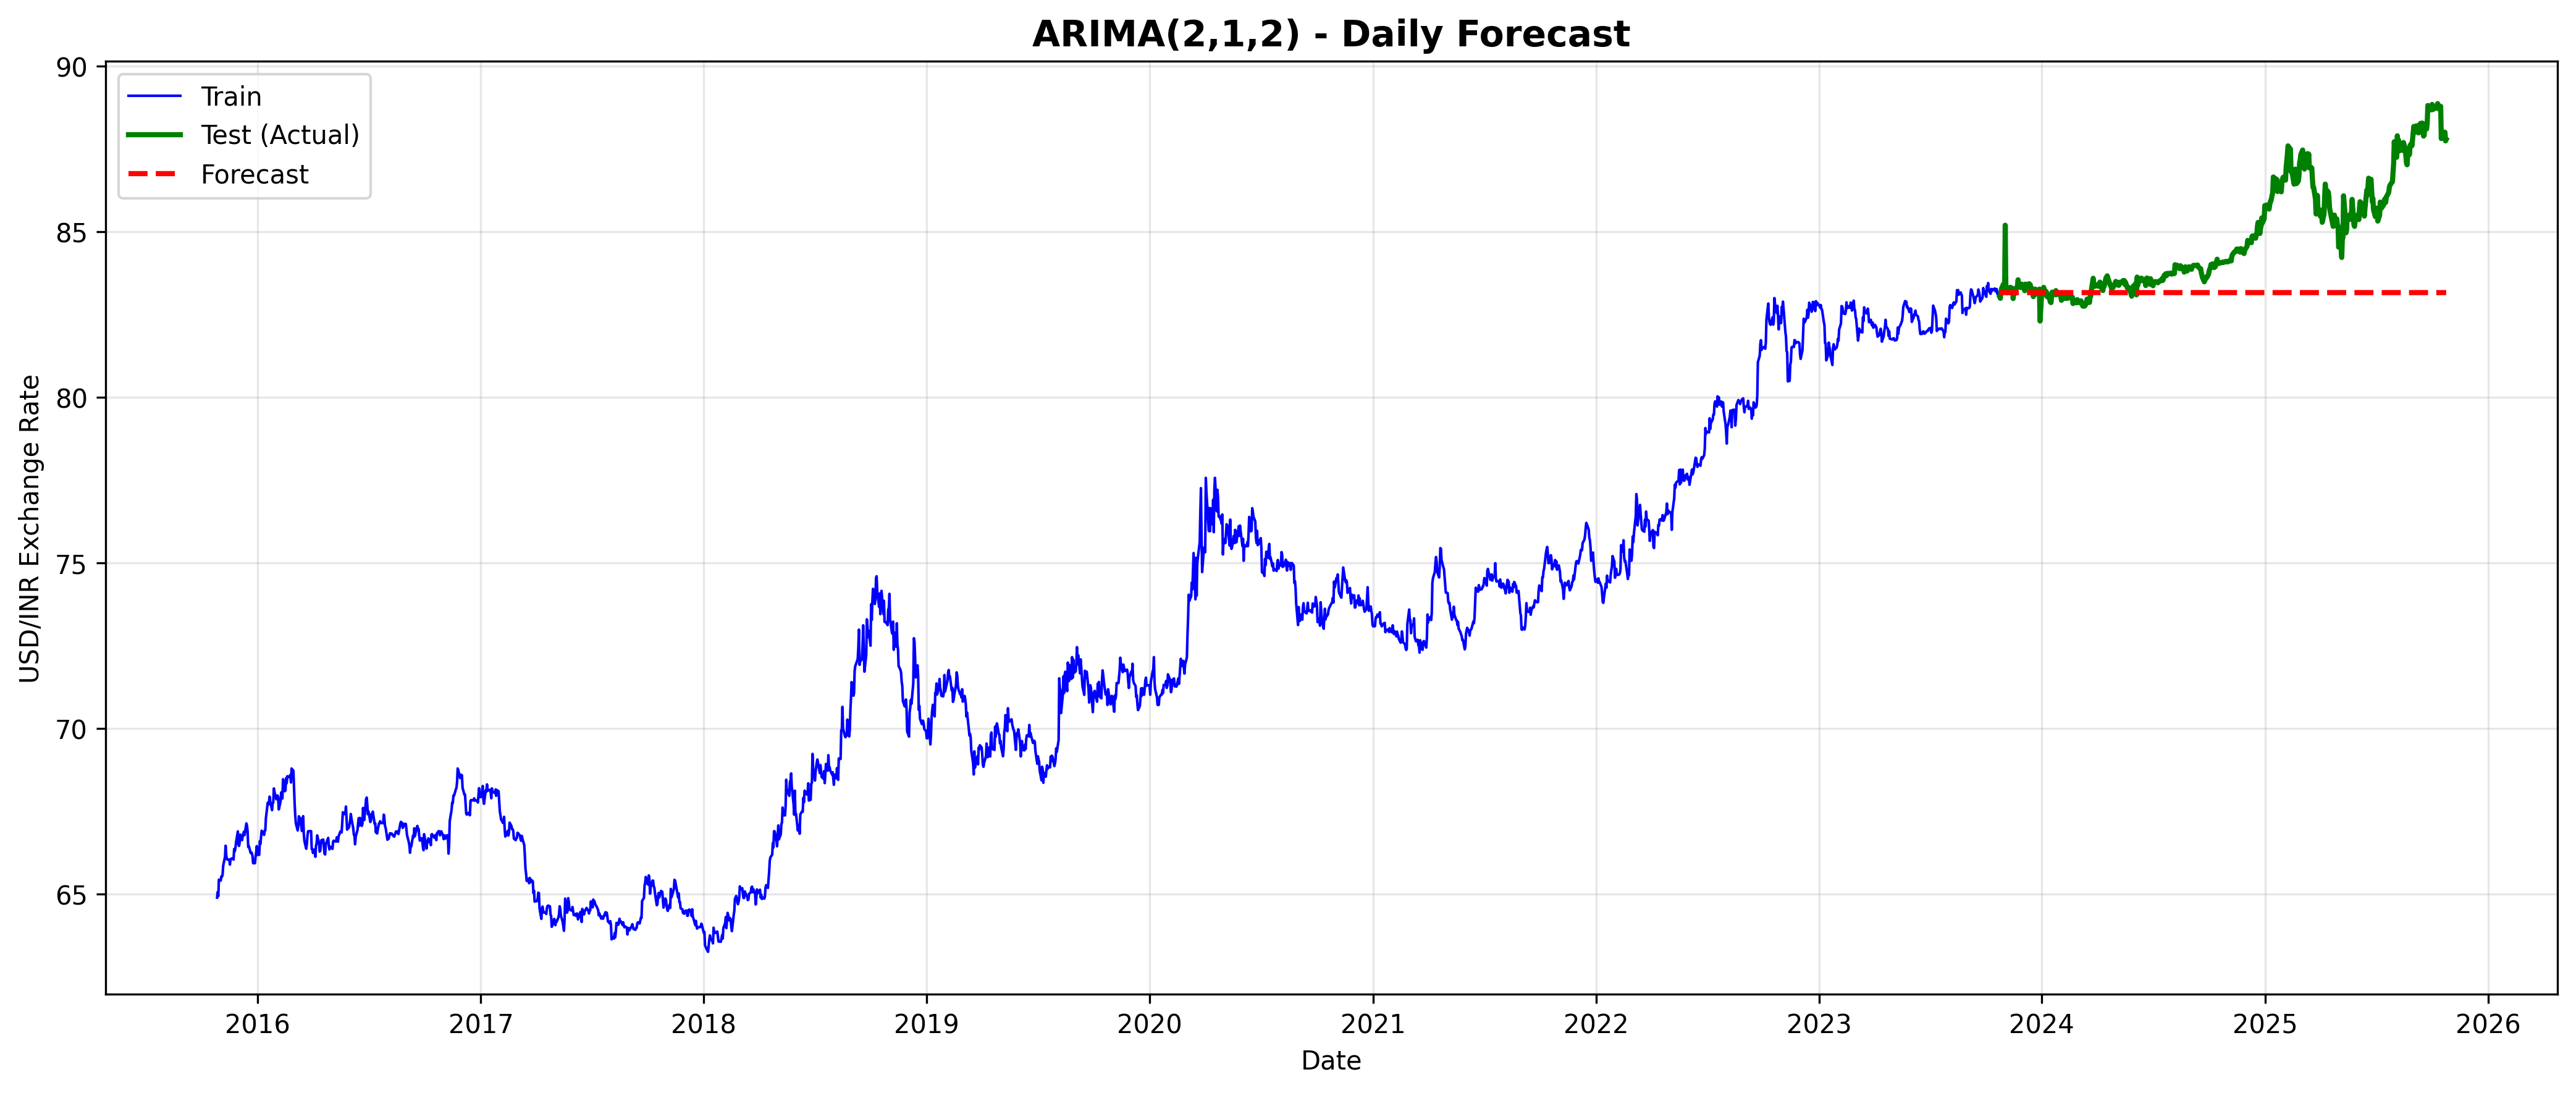

In [41]:
print("\n" + "─"*70)
print("[Model 3] Auto ARIMA - Daily (Grid Search)")
print("─"*70)

print("\nSearching for best ARIMA parameters...")
print("Testing combinations of p=[0,1,2,3], d=[0,1], q=[0,1,2,3]")

best_aic = np.inf
best_order = None
best_model = None

# Grid search
for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(train_daily, order=(p,d,q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p, d, q)
                    best_model = fitted
            except:
                continue

print(f"\n✓ Best ARIMA order: {best_order}")
print(f"  AIC: {best_aic:.2f}")
print(f"  BIC: {best_model.bic:.2f}")

# Forecast with best model
forecast_auto_arima = best_model.forecast(steps=len(test_daily))

# Evaluate
results_auto_arima = evaluate_forecast(test_daily.values, forecast_auto_arima.values, 
                                       f"Auto ARIMA{best_order}")

# Plot
plot_forecast(train_daily, test_daily, forecast_auto_arima, 
              f'Auto ARIMA{best_order} - Daily Forecast', '10_daily_auto_arima.png')



──────────────────────────────────────────────────────────────────────
[Model 3] Auto ARIMA - Daily (Grid Search)
──────────────────────────────────────────────────────────────────────

Searching for best ARIMA parameters...
Testing combinations of p=[0,1,2,3], d=[0,1], q=[0,1,2,3]

✓ Best ARIMA order: (3, 1, 3)
  AIC: 562.24
  BIC: 601.72

Auto ARIMA(3, 1, 3) Performance:
  RMSE: 2.391110
  MAE: 1.716116
  MAPE: 1.9847%
  Directional Accuracy: 51.54%
  ✓ Saved: 10_daily_auto_arima.png


                               SARIMAX Results                                
Dep. Variable:                USD_INR   No. Observations:                 2603
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -301.987
Date:                Sun, 26 Oct 2025   AIC                            605.974
Time:                        21:35:44   BIC                            611.838
Sample:                             0   HQIC                           608.099
                               - 2603                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0738      0.001     75.717      0.000       0.072       0.076
Ljung-Box (L1) (Q):                  75.21   Jarque-Bera (JB):              5046.00
Prob(Q):                              0.00   Pr

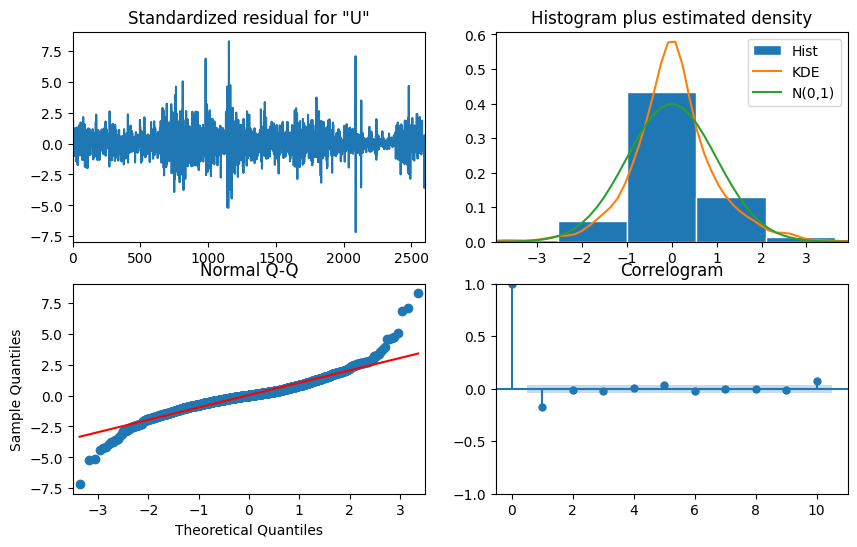

In [61]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(daily_df['USD_INR'], order=(0,1,0))
result = model.fit()
print(result.summary())


result.plot_diagnostics(figsize=(10,6))
plt.show()


                               SARIMAX Results                                
Dep. Variable:                USD_INR   No. Observations:                 2603
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -264.431
Date:                Sun, 26 Oct 2025   AIC                            532.862
Time:                        21:35:54   BIC                            544.590
Sample:                             0   HQIC                           537.111
                               - 2603                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1687      0.011    -14.830      0.000      -0.191      -0.146
sigma2         0.0717      0.001     74.183      0.000       0.070       0.074
Ljung-Box (L1) (Q):                   0.18   Jarque-

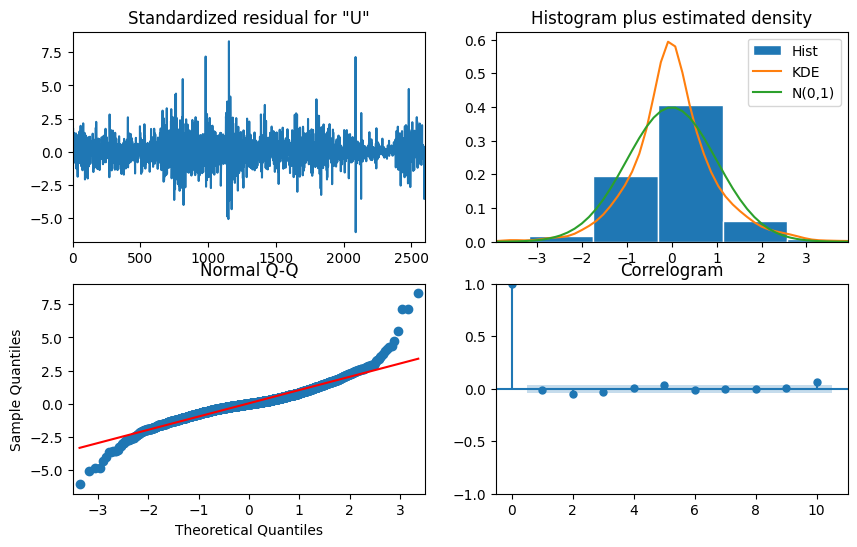

In [62]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(daily_df['USD_INR'], order=(1,1,0))
result = model.fit()
print(result.summary())


result.plot_diagnostics(figsize=(10,6))
plt.show()


bringing all above models together and doing collectively


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

train_size = int(len(daily_df) * 0.8)
train = daily_df['USD_INR'][:train_size]
test = daily_df['USD_INR'][train_size:]

models_to_test = [
    (0, 1, 0),  # Random walk
    (1, 1, 0),  # AR(1)
    (0, 1, 1),  # MA(1)
    (1, 1, 1),  # ARMA(1,1)
]

results = []
for order in models_to_test:
    try:
        model = ARIMA(train, order=order)
        fitted = model.fit()
        
        # Forecast
        forecast = fitted.forecast(steps=len(test))
        
        # Metrics
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        
        results.append({
            'Model': f'ARIMA{order}',
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'RMSE': rmse,
            'MAE': mae
        })
        
        print(f"ARIMA{order}:")
        print(f"  AIC: {fitted.aic:.2f}")
        print(f"  BIC: {fitted.bic:.2f}")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAE: {mae:.6f}\n")
        
    except Exception as e:
        print(f"ARIMA{order}: Failed - {e}\n")

results_df = pd.DataFrame(results)
print(results_df.sort_values('AIC'))

ARIMA(0, 1, 0):
  AIC: 632.81
  BIC: 638.45
  RMSE: 2.397279
  MAE: 1.722656

ARIMA(1, 1, 0):
  AIC: 585.08
  BIC: 596.36
  RMSE: 2.400781
  MAE: 1.726456

ARIMA(0, 1, 1):
  AIC: 582.34
  BIC: 593.62
  RMSE: 2.398879
  MAE: 1.724392

ARIMA(1, 1, 1):
  AIC: 583.59
  BIC: 600.51
  RMSE: 2.396971
  MAE: 1.722324

            Model         AIC         BIC      RMSE       MAE
2  ARIMA(0, 1, 1)  582.341294  593.622501  2.398879  1.724392
3  ARIMA(1, 1, 1)  583.587116  600.508928  2.396971  1.722324
1  ARIMA(1, 1, 0)  585.079319  596.360527  2.400781  1.726456
0  ARIMA(0, 1, 0)  632.807182  638.447785  2.397279  1.722656


ARIMA(0, 1, 1) - Best Overall

Lowest AIC: 582.34 (best model fit)
Lowest BIC: 593.62 
RMSE: 2.399 (3rd place, very close)
MAE: 1.724 (3rd place, very close)

Why choose ARIMA(0,1,1)?

Best balance of simplicity and fit
BIC prefers simpler models (penalizes complexity more)
Differences in forecast accuracy are negligible (all within 0.004!)

PROPHET MODEL


In [64]:
prophet_df = pd.DataFrame({
    'ds': daily_df.index,
    'y': daily_df['USD_INR'].values
})

print(f"✓ Data loaded: {len(prophet_df)} days")
print(f"  Date range: {prophet_df['ds'].min().date()} to {prophet_df['ds'].max().date()}")


✓ Data loaded: 2603 days
  Date range: 2015-10-27 to 2025-10-24


In [65]:
prophet_df

ds          y
0    2015-10-27  64.901001
1    2015-10-28  65.067001
2    2015-10-29  64.945999
3    2015-10-30  65.444000
4    2015-11-02  65.415001
...         ...        ...
2598 2025-10-20  88.002296
2599 2025-10-21  87.879997
2600 2025-10-22  88.001602
2601 2025-10-23  87.740303
2602 2025-10-24  87.778999

[2603 rows x 2 columns]

In [66]:
# Train-test split (80-20)
train_size = int(len(prophet_df) * 0.8)
train = prophet_df[:train_size].copy()
test = prophet_df[train_size:].copy()

print(f"\n Train: {len(train)} days ({train['ds'].min().date()} to {train['ds'].max().date()})")
print(f" Test:  {len(test)} days ({test['ds'].min().date()} to {test['ds'].max().date()})")



 Train: 2082 days (2015-10-27 to 2023-10-23)
 Test:  521 days (2023-10-24 to 2025-10-24)


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [74]:
def evaluate_prophet(actual, predicted, model_name):
    """Evaluate Prophet forecasts"""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    
    # Directional accuracy
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    directional_accuracy = np.mean((actual_diff > 0) == (pred_diff > 0)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  MAPE: {mape:.4f}%")
    print(f"  Directional Accuracy: {directional_accuracy:.2f}%")
    
    return {
        'Model': model_name,
        'RMSE': rmse, 
        'MAE': mae, 
        'MAPE': mape, 
        'Dir_Acc': directional_accuracy
    }

def plot_prophet_results(train, test, forecast, model_name, filename):
    """Plot Prophet forecast vs actual"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Full timeline
    axes[0].plot(train['ds'], train['y'], label='Train', color='blue', linewidth=1)
    axes[0].plot(test['ds'], test['y'], label='Actual Test', color='green', linewidth=2)
    axes[0].plot(forecast['ds'], forecast['yhat'], label='Forecast', 
                 color='red', linewidth=2, linestyle='--')
    axes[0].fill_between(forecast['ds'], 
                         forecast['yhat_lower'], 
                         forecast['yhat_upper'],
                         alpha=0.3, color='red', label='Uncertainty')
    axes[0].set_title(f'{model_name} - Full Timeline', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('USD/INR')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Test period only (zoomed)
    axes[1].plot(test['ds'], test['y'], label='Actual', color='green', 
                 linewidth=2, marker='o', markersize=3)
    axes[1].plot(forecast['ds'], forecast['yhat'], label='Forecast', 
                 color='red', linewidth=2, marker='x', markersize=3, linestyle='--')
    axes[1].fill_between(forecast['ds'],
                         forecast['yhat_lower'],
                         forecast['yhat_upper'],
                         alpha=0.3, color='red', label='Uncertainty')
    axes[1].set_title(f'{model_name} - Test Period (Zoomed)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('USD/INR')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: {filename}")
    plt.close()


In [75]:
model_default = Prophet(
    daily_seasonality=False,  # Too noisy for daily FX data
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05  # Default
)

model_default.fit(train)
print("✓ Model trained")

21:43:49 - cmdstanpy - INFO - Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing


✓ Model trained


In [76]:
future_default = model_default.make_future_dataframe(periods=len(test))
forecast_default = model_default.predict(future_default)


In [77]:
# Get test period forecasts
test_forecast_default = forecast_default.tail(len(test)).copy()


In [78]:
# Evaluate
results_default = evaluate_prophet(
    test['y'].values,
    test_forecast_default['yhat'].values,
    "Prophet (Default)"
)


Prophet (Default) Performance:
  RMSE: 2.781699
  MAE:  2.663562
  MAPE: 3.1427%
  Directional Accuracy: 55.77%


In [81]:
# Plot
plot_prophet_results(train, test, test_forecast_default,
                    "Prophet Default", "prophet_default_forecast.png")

# Plot components
fig1 = model_default.plot_components(forecast_default, figsize=(14, 10))
plt.tight_layout()
plt.savefig('prophet_default_components.png')
print("  ✓ Saved: prophet_default_components.png")
plt.close()

  ✓ Saved: prophet_default_forecast.png
  ✓ Saved: prophet_default_components.png


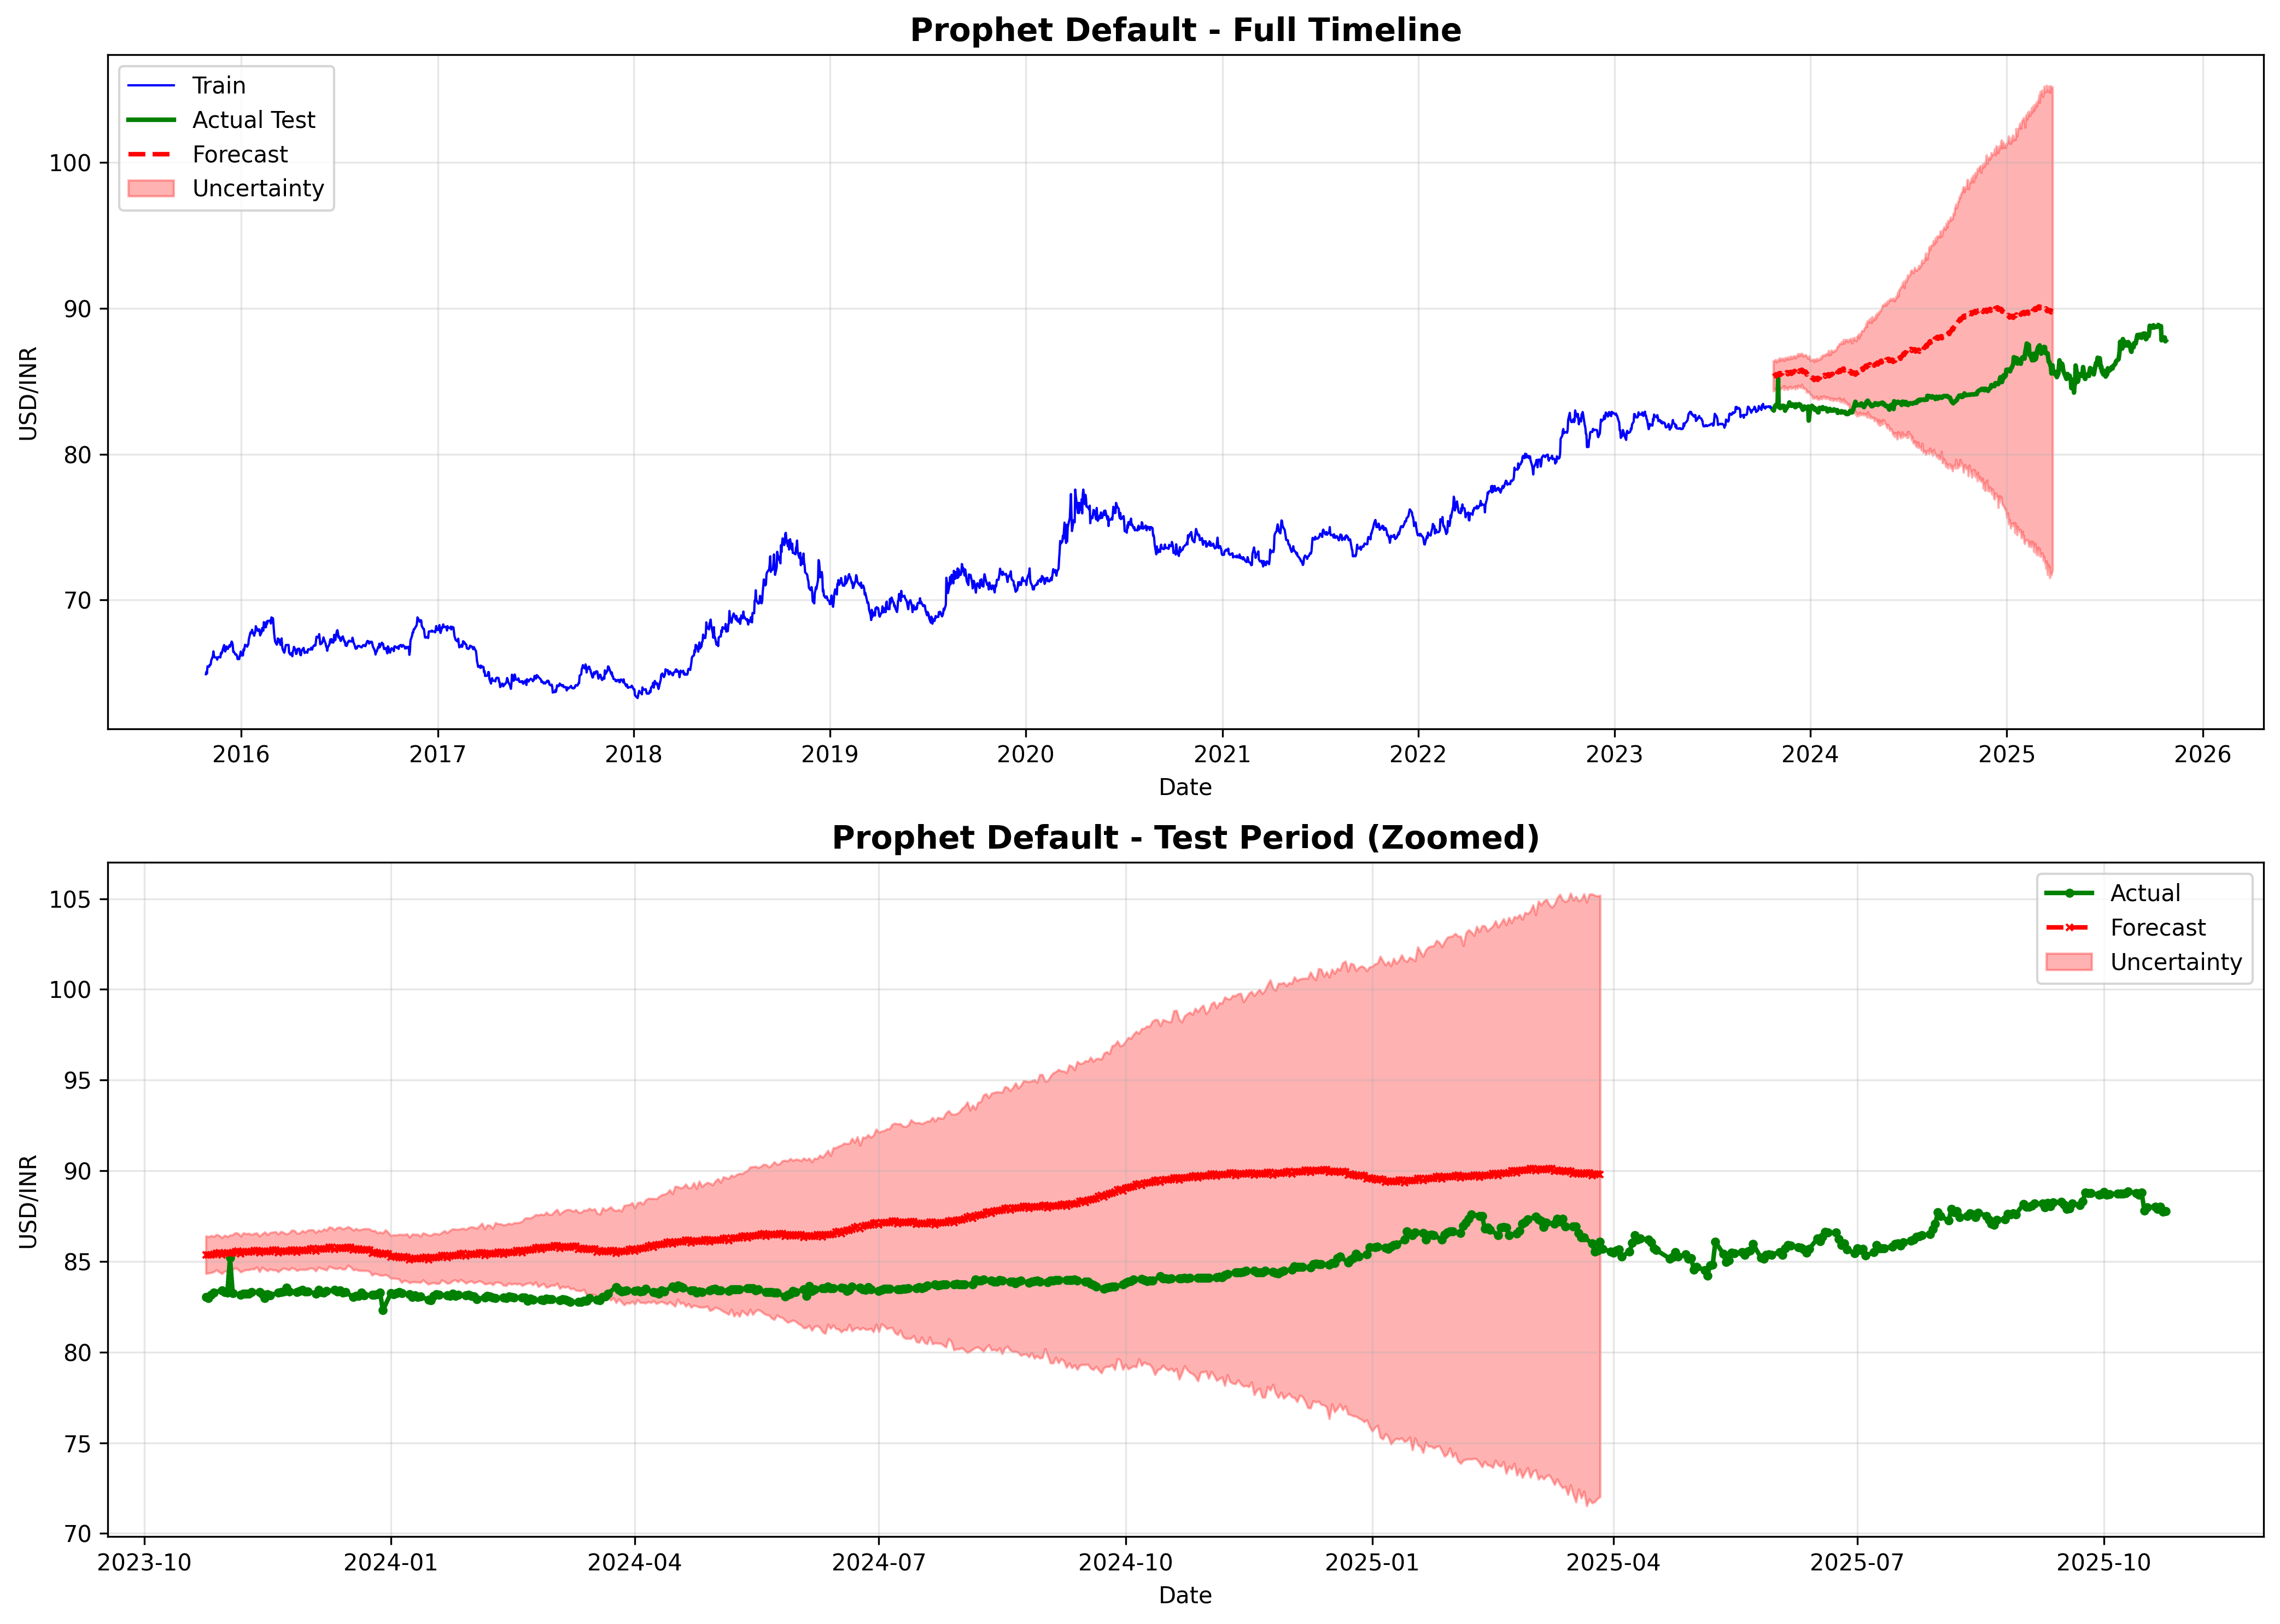

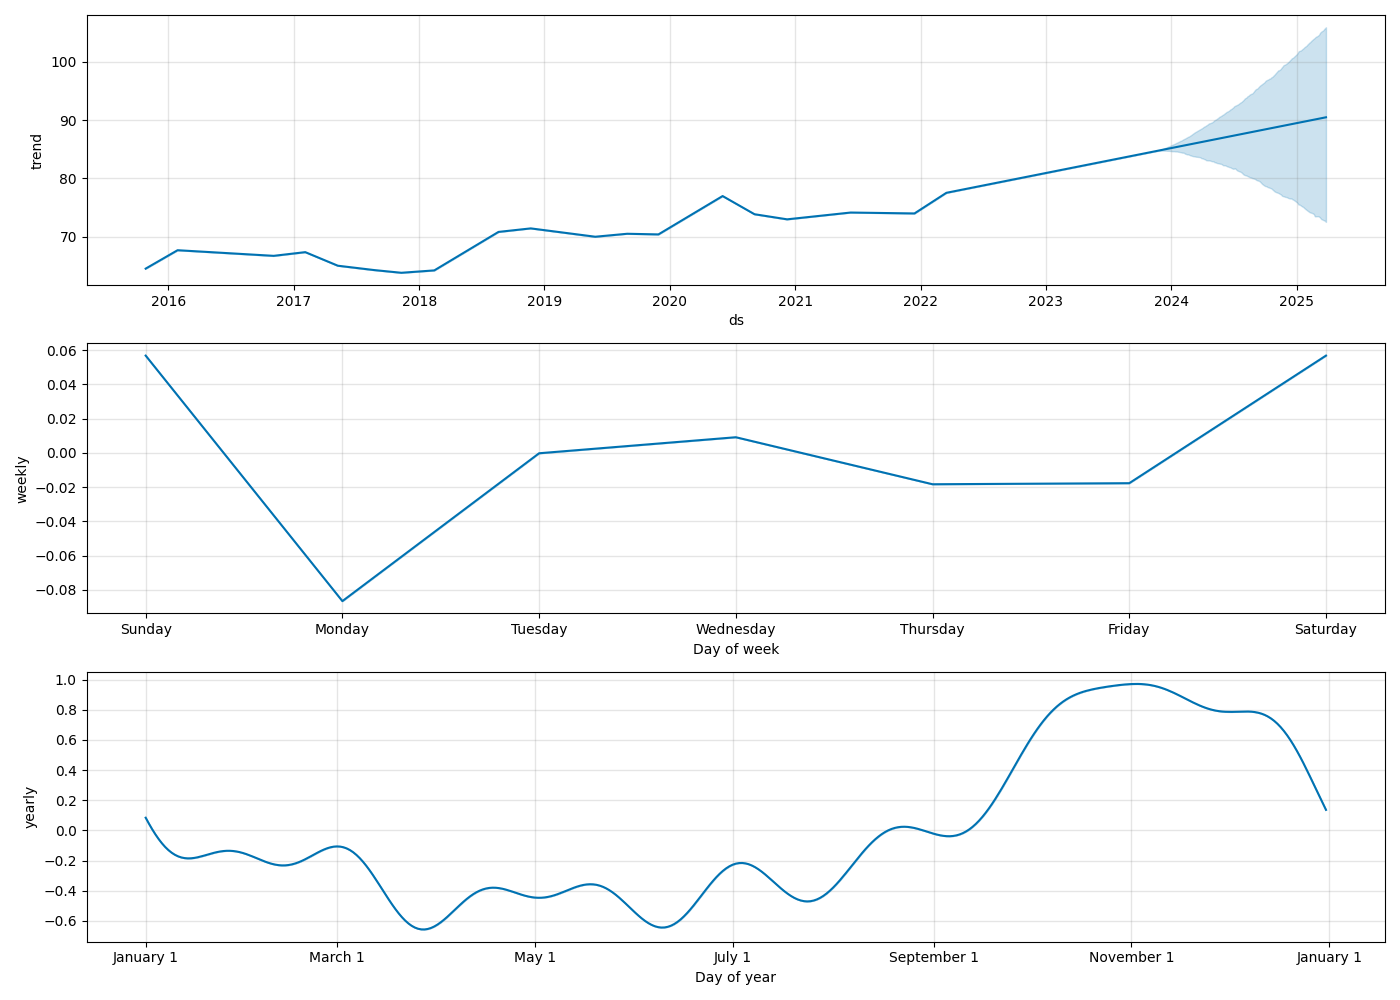

forecastinggg

Train size: 2082
Test size: 521

Fitting ARIMA(0,1,1) model...

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                USD_INR   No. Observations:                 2082
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -289.171
Date:                Sun, 26 Oct 2025   AIC                            582.341
Time:                        21:49:01   BIC                            593.623
Sample:                             0   HQIC                           586.475
                               - 2082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1626      0.015    -10.769      0.000      -0.192      -0.133
sigma2         0.0773      0.001     60.296      0.0

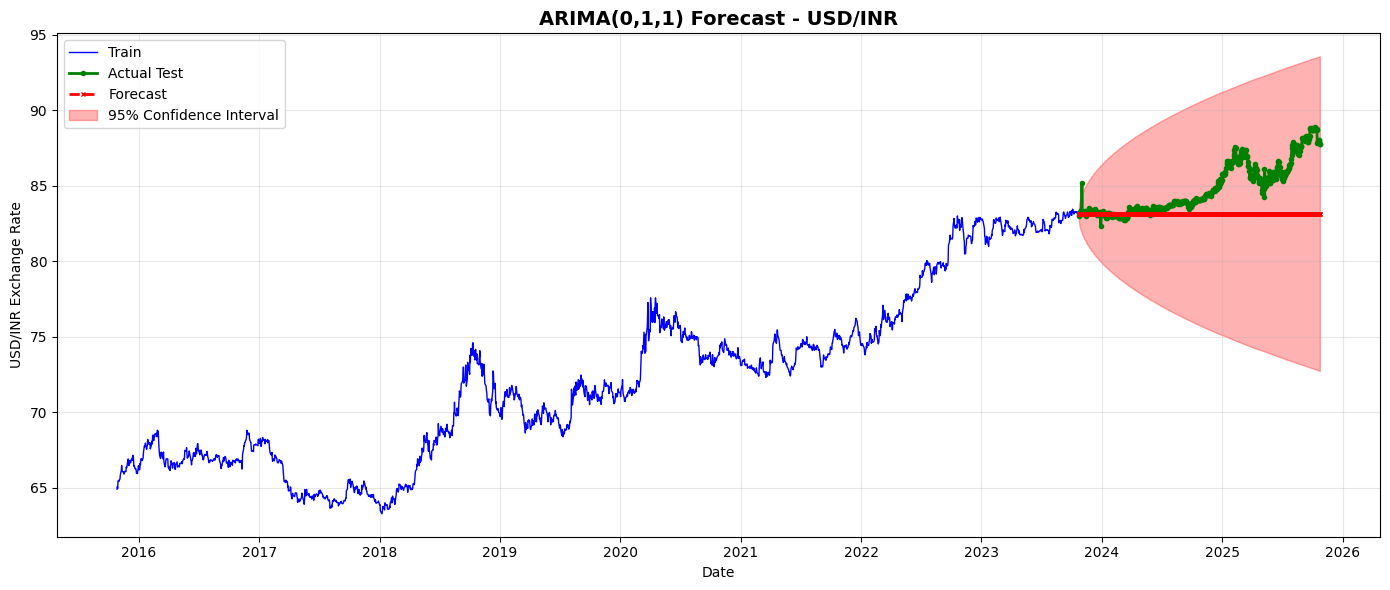


Future Forecast (Next 30 days):
        Date   Forecast   Lower_CI   Upper_CI
0 2025-10-25  87.779911  87.255423  88.304398
1 2025-10-26  87.779911  87.101592  88.458229
2 2025-10-27  87.779911  86.976701  88.583120
3 2025-10-28  87.779911  86.868771  88.691050
4 2025-10-29  87.779911  86.772337  88.787484
5 2025-10-30  87.779911  86.684359  88.875462
6 2025-10-31  87.779911  86.602939  88.956882
7 2025-11-01  87.779911  86.526798  89.033023
8 2025-11-02  87.779911  86.455026  89.104796
9 2025-11-03  87.779911  86.386946  89.172875

✓ Saved: arima_011_future_forecast.csv
✓ Saved: arima_011_future_forecast.png


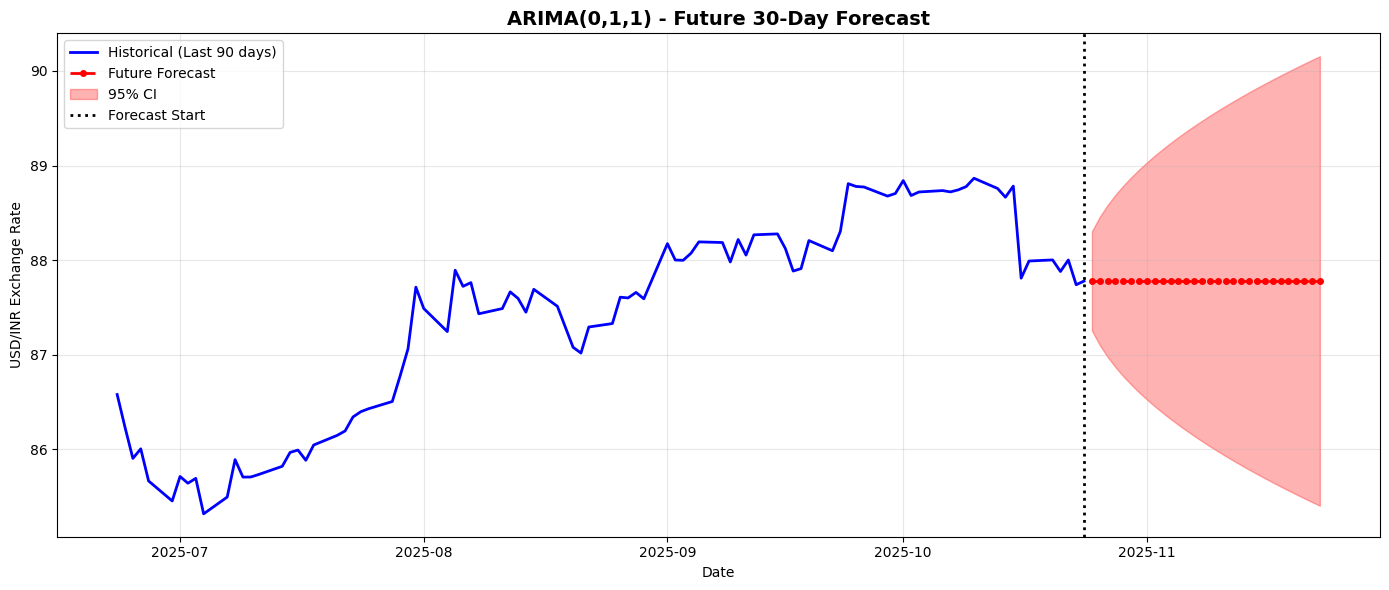


One-Step-Ahead Performance:
  RMSE: 0.221373
  MAE:  0.127165

✓ ARIMA(0,1,1) FORECASTING COMPLETED!


In [84]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# STEP 1: PREPARE DATA
# ============================================
daily_df = pd.read_csv('usd_inr_daily_raw.csv', index_col=0, parse_dates=True)

# Train-test split (80-20)
train_size = int(len(daily_df) * 0.8)
train = daily_df['USD_INR'][:train_size]
test = daily_df['USD_INR'][train_size:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

# ============================================
# STEP 2: FIT ARIMA(0,1,1) MODEL
# ============================================
print("\nFitting ARIMA(0,1,1) model...")

model = ARIMA(train, order=(0, 1, 1))
fitted_model = model.fit()

print("\nModel Summary:")
print(fitted_model.summary())

# ============================================
# STEP 3: MAKE FORECASTS
# ============================================

# Method A: Forecast test period (out-of-sample)
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)

print(f"\nForecast for next {forecast_steps} days:")
print(forecast.head(10))

# ============================================
# STEP 4: GET PREDICTION INTERVALS
# ============================================
# Get forecast with confidence intervals
forecast_obj = fitted_model.get_forecast(steps=forecast_steps)
forecast_df = forecast_obj.summary_frame()

print("\nForecast with confidence intervals:")
print(forecast_df.head())
print("\nColumns:", forecast_df.columns.tolist())

# ============================================
# STEP 5: EVALUATE FORECAST
# ============================================
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

print(f"\nForecast Performance:")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")

# ============================================
# STEP 6: VISUALIZE FORECAST
# ============================================
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train.index, train.values, label='Train', color='blue', linewidth=1)

# Plot actual test data
plt.plot(test.index, test.values, label='Actual Test', 
         color='green', linewidth=2, marker='o', markersize=3)

# Plot forecast
plt.plot(test.index, forecast.values, label='Forecast', 
         color='red', linewidth=2, linestyle='--', marker='x', markersize=3)

# Plot confidence intervals
plt.fill_between(test.index, 
                 forecast_df['mean_ci_lower'].values,
                 forecast_df['mean_ci_upper'].values,
                 alpha=0.3, color='red', label='95% Confidence Interval')

plt.title('ARIMA(0,1,1) Forecast - USD/INR', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('USD/INR Exchange Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('arima_011_forecast.png', dpi=300)
print("\n✓ Saved: arima_011_forecast.png")
plt.show()

# ============================================
# STEP 7: FORECAST FUTURE (BEYOND TEST SET)
# ============================================
# Refit on ALL data for future predictions
model_full = ARIMA(daily_df['USD_INR'], order=(0, 1, 1))
fitted_full = model_full.fit()

# Forecast next 30 days into future
future_steps = 30
future_forecast = fitted_full.forecast(steps=future_steps)
future_forecast_obj = fitted_full.get_forecast(steps=future_steps)
future_df = future_forecast_obj.summary_frame()

# Create future dates
last_date = daily_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                              periods=future_steps, freq='D')

print(f"\nFuture Forecast (Next {future_steps} days):")
future_results = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_forecast.values,
    'Lower_CI': future_df['mean_ci_lower'].values,
    'Upper_CI': future_df['mean_ci_upper'].values
})
print(future_results.head(10))

# Save future forecast
future_results.to_csv('arima_011_future_forecast.csv', index=False)
print("\n✓ Saved: arima_011_future_forecast.csv")

# ============================================
# STEP 8: PLOT FUTURE FORECAST
# ============================================
plt.figure(figsize=(14, 6))

# Plot last 90 days of historical data
historical_last = daily_df['USD_INR'].tail(90)
plt.plot(historical_last.index, historical_last.values, 
         label='Historical (Last 90 days)', color='blue', linewidth=2)

# Plot future forecast
plt.plot(future_dates, future_forecast.values, 
         label='Future Forecast', color='red', linewidth=2, 
         linestyle='--', marker='o', markersize=4)

# Plot confidence intervals
plt.fill_between(future_dates,
                 future_df['mean_ci_lower'].values,
                 future_df['mean_ci_upper'].values,
                 alpha=0.3, color='red', label='95% CI')

plt.axvline(last_date, color='black', linestyle=':', 
            linewidth=2, label='Forecast Start')

plt.title('ARIMA(0,1,1) - Future 30-Day Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('USD/INR Exchange Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('arima_011_future_forecast.png', dpi=300)
print("✓ Saved: arima_011_future_forecast.png")
plt.show()

# ============================================
# STEP 9: ONE-STEP-AHEAD PREDICTIONS
# ============================================
# For walk-forward validation (more realistic)
predictions = []
history = train.tolist()

for i in range(len(test)):
    model_temp = ARIMA(history, order=(0, 1, 1))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)[0]
    predictions.append(pred)
    history.append(test.iloc[i])  # Add actual value to history

predictions = np.array(predictions)

# Evaluate one-step-ahead
rmse_onestep = np.sqrt(mean_squared_error(test, predictions))
mae_onestep = mean_absolute_error(test, predictions)

print(f"\nOne-Step-Ahead Performance:")
print(f"  RMSE: {rmse_onestep:.6f}")
print(f"  MAE:  {mae_onestep:.6f}")

print("\n" + "="*70)
print("✓ ARIMA(0,1,1) FORECASTING COMPLETED!")
print("="*70)

cg

In [5]:
df = pd.read_csv("usd_inr_daily_raw.csv", parse_dates=["Date"])


In [6]:
df = df.sort_values("Date").set_index("Date")

In [7]:
df

USD_INR  daily_diff
Date                             
2015-10-27  64.901001         NaN
2015-10-28  65.067001   64.901001
2015-10-29  64.945999   65.067001
2015-10-30  65.444000   64.945999
2015-11-02  65.415001   65.444000
...               ...         ...
2025-10-20  88.002296   87.990700
2025-10-21  87.879997   88.002296
2025-10-22  88.001602   87.879997
2025-10-23  87.740303   88.001602
2025-10-24  87.778999   87.740303

[2603 rows x 2 columns]

In [8]:
df=df.rename(columns={'USD_INR': 'Close'})

In [9]:
df

Close  daily_diff
Date                             
2015-10-27  64.901001         NaN
2015-10-28  65.067001   64.901001
2015-10-29  64.945999   65.067001
2015-10-30  65.444000   64.945999
2015-11-02  65.415001   65.444000
...               ...         ...
2025-10-20  88.002296   87.990700
2025-10-21  87.879997   88.002296
2025-10-22  88.001602   87.879997
2025-10-23  87.740303   88.001602
2025-10-24  87.778999   87.740303

[2603 rows x 2 columns]

In [10]:
df.isnull().sum()

Close         0
daily_diff    1
dtype: int64

In [11]:
series = df["Close"].asfreq("B")  # business day frequency
series = series.interpolate(method="time")  # fill missing trading days by time interpolation


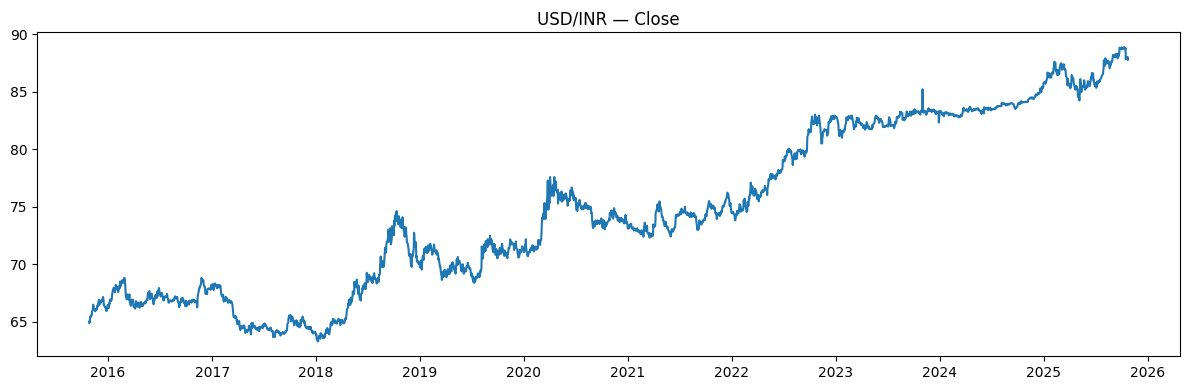

In [12]:
plt.figure(figsize=(12,4))
plt.plot(series)
plt.title("USD/INR — Close")
plt.tight_layout()
plt.show()

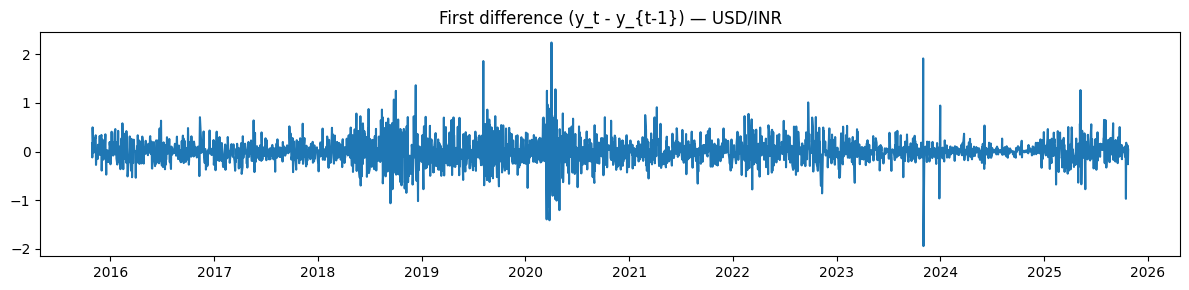

In [59]:
fd = series.diff().dropna()

plt.figure(figsize=(12,3))
plt.plot(fd)
plt.title("First difference (y_t - y_{t-1}) — USD/INR")
plt.tight_layout()
plt.show()

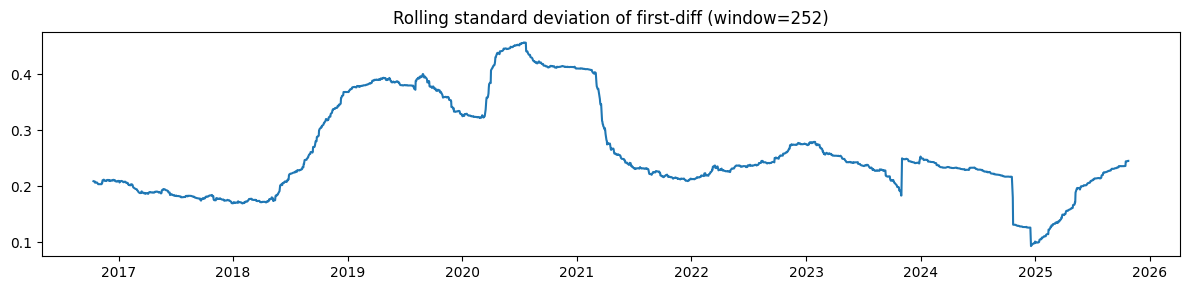

In [ ]:
# rolling std to check heteroskedasticity / non-constant variance
roll_std = fd.rolling(window=252).std()
plt.figure(figsize=(12,3))
plt.plot(roll_std)
plt.title("Rolling standard deviation of first-diff (window=252)")
plt.tight_layout()
plt.show()


In [ ]:
#adf test without fd
def adf_test(x, signif=0.05):
    res = adfuller(x, autolag='AIC')
    out = {
        "ADF Statistic": res[0],
        "p-value": res[1],
        "Used lags": res[2],
        "nobs": res[3],
        "Critical Values": res[4]
    }
    print(">>> ADF test")
    for k,v in out.items():
        print(f"{k}: {v}")
    if res[1] < signif:
        print("=> Reject H0 (series is likely stationary)")
    else:
        print("=> Fail to reject H0 (series is likely non-stationary)")
    print()

def kpss_test(x, signif=0.05, regression='c'):
    res = kpss(x, regression=regression, nlags="auto")
    out = {
        "KPSS Statistic": res[0],
        "p-value": res[1],
        "Used lags": res[2],
        "Critical Values": res[3]
    }
    print(">>> KPSS test (null: stationary)")
    for k,v in out.items():
        print(f"{k}: {v}")
    if res[1] < signif:
        print("=> Reject H0 (series is likely non-stationary)")
    else:
        print("=> Fail to reject H0 (series is likely stationary)")
    print()

print("Stationarity tests on original series:")



adf_test(series.dropna())
kpss_test(series.dropna())

Stationarity tests on original series:
>>> ADF test
ADF Statistic: -0.2114654927206787
p-value: 0.937141090422113
Used lags: 10
nobs: 2598
Critical Values: {'1%': np.float64(-3.4328695430687004), '5%': np.float64(-2.8626531392022194), '10%': np.float64(-2.5673625639785684)}
=> Fail to reject H0 (series is likely non-stationary)

>>> KPSS test (null: stationary)
KPSS Statistic: 8.048133678905463
p-value: 0.01
Used lags: 30
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Reject H0 (series is likely non-stationary)



In [ ]:
#adf test after fd
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x, signif=0.05):
    """
    Augmented Dickey-Fuller Test
    H0: Series has a unit root (non-stationary)
    """
    x = x.dropna()
    res = adfuller(x, autolag='AIC')
    output = {
        "Test": "ADF",
        "ADF Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "N Observations": res[3],
        "Critical Values": res[4]
    }

  
    print(">>> Augmented Dickey-Fuller (ADF) Test")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is stationary")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is  non-stationary** ")
    print()

    return output


def kpss_test(x, signif=0.05, regression='c'):
    """
    KPSS Test
    H0: Series is stationary
    """
    x = x.dropna()
    res = kpss(x, regression=regression, nlags="auto")
    output = {
        "Test": "KPSS",
        "KPSS Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "Critical Values": res[3]
    }
    print(f">>> KPSS Test (regression='{regression}')")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is **likely non-stationary** ")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is stationary ")
    print()

    return output

adf_res = adf_test(fd)
kpss_res = kpss_test(fd)


>>> Augmented Dickey-Fuller (ADF) Test
Test: ADF
ADF Statistic: -15.558783776277751
p-value: 2.0551961725812493e-28
Used Lags: 9
N Observations: 2598
Critical Values: {'1%': np.float64(-3.4328695430687004), '5%': np.float64(-2.8626531392022194), '10%': np.float64(-2.5673625639785684)}
=> Reject H₀ at 0.05 level → Series is stationary

>>> KPSS Test (regression='c')
Test: KPSS
KPSS Statistic: 0.05257319530158344
p-value: 0.1
Used Lags: 4
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Fail to reject H₀ at 0.05 level → Series is stationary 



<Figure size 1200x300 with 0 Axes>

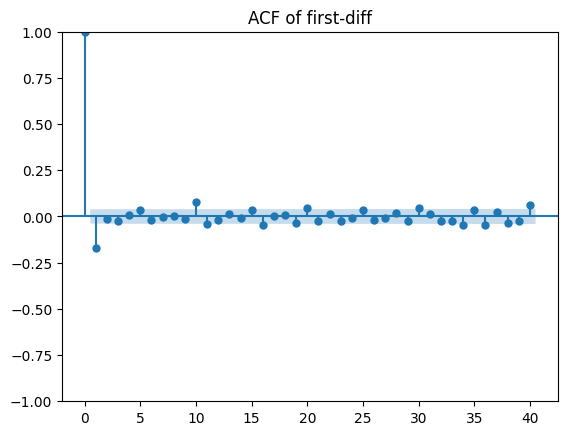

<Figure size 1200x300 with 0 Axes>

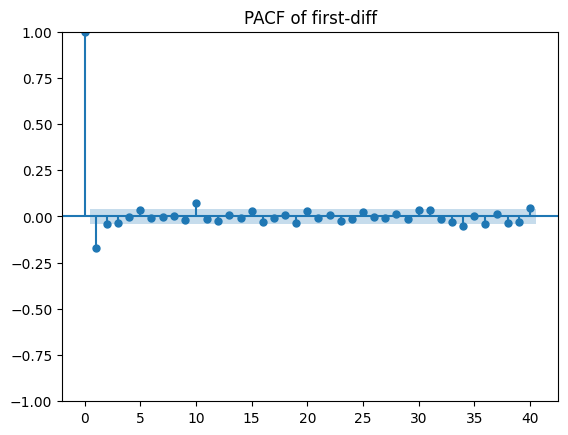

In [30]:
# --- ACF / PACF ---
plt.figure(figsize=(12,3))
plot_acf(fd, lags=40, alpha=0.05)
plt.title("ACF of first-diff")
plt.show()

plt.figure(figsize=(12,3))
plot_pacf(fd, lags=40, method='ywm', alpha=0.05)
plt.title("PACF of first-diff")
plt.show()

What ACF Shows
Lag 1 (the first bar)
There’s a strong negative spike at lag 1 (around -0.25).
→ This means the first-differenced series has a negative autocorrelation between consecutive values.
→ Typical of a random walk after differencing — the series overshoots slightly from one step to the next.

Lags > 1

Beyond lag 1, all bars lie within the confidence bands (the shaded region).
→ This means no significant autocorrelation at higher lags.
→ The series behaves like white noise — random, unpredictable fluctuations.
p = 0 → No AR terms (ACF doesn’t show persistence)

d = 1 → First differencing (as confirmed)

q = 1 → One MA term (ACF cuts off after lag 1)

trying log diff

In [ ]:
series = df["Close"].asfreq("B")
series = series.interpolate(method="time")

# log transform
log_y = np.log(series)


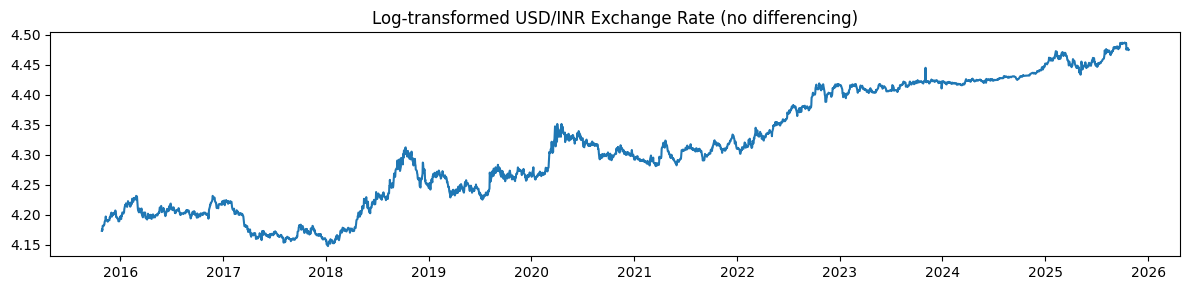

In [32]:
plt.figure(figsize=(12,3))
plt.plot(log_y)
plt.title("Log-transformed USD/INR Exchange Rate (no differencing)")
plt.tight_layout()
plt.show()

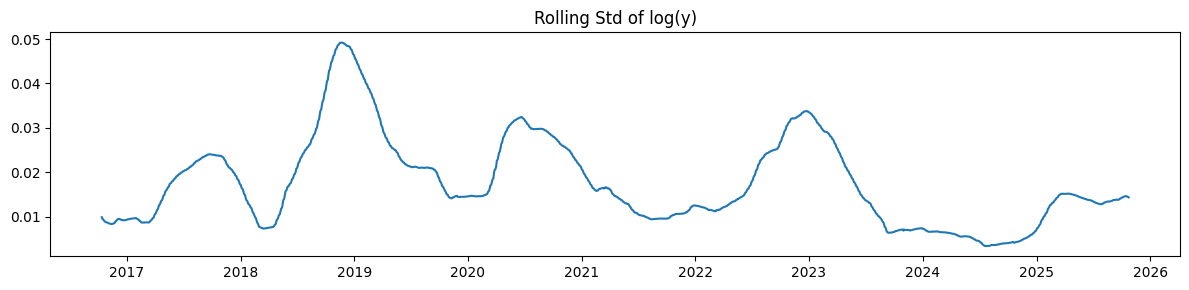

In [ ]:
# rolling std
roll_std_log = log_y.rolling(window=252).std()
plt.figure(figsize=(12,3))
plt.plot(roll_std_log)
plt.title("Rolling Std of log(y)")
plt.tight_layout()
plt.show()

In [41]:
#adf test after fd
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x, signif=0.05):
    """
    Augmented Dickey-Fuller Test
    H0: Series has a unit root (non-stationary)
    """
    x = x.dropna()
    res = adfuller(x, autolag='AIC')
    output = {
        "Test": "ADF",
        "ADF Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "N Observations": res[3],
        "Critical Values": res[4]
    }

  
    print(">>> Augmented Dickey-Fuller (ADF) Test")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is stationary")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is  non-stationary** ")
    print()

    return output




def kpss_test(x, signif=0.05, regression='c'):
    """
    KPSS Test
    H0: Series is stationary
    """
    x = x.dropna()
    res = kpss(x, regression=regression, nlags="auto")
    output = {
        "Test": "KPSS",
        "KPSS Statistic": res[0],
        "p-value": res[1],
        "Used Lags": res[2],
        "Critical Values": res[3]
    }
    print(f">>> KPSS Test (regression='{regression}')")
    for k, v in output.items():
        if k != "Critical Values":
            print(f"{k}: {v}")
    print("Critical Values:", output["Critical Values"])
    
    if res[1] < signif:
        print(f"=> Reject H₀ at {signif} level → Series is **likely non-stationary** ")
    else:
        print(f"=> Fail to reject H₀ at {signif} level → Series is stationary ")
    print()

    return output

adf_res = adf_test(log_y)
kpss_res = kpss_test(log_y)


>>> Augmented Dickey-Fuller (ADF) Test
Test: ADF
ADF Statistic: -0.3540333169077805
p-value: 0.9174953155103163
Used Lags: 10
N Observations: 2598
Critical Values: {'1%': np.float64(-3.4328695430687004), '5%': np.float64(-2.8626531392022194), '10%': np.float64(-2.5673625639785684)}
=> Fail to reject H₀ at 0.05 level → Series is  non-stationary** 

>>> KPSS Test (regression='c')
Test: KPSS
KPSS Statistic: 8.050069864730299
p-value: 0.01
Used Lags: 30
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Reject H₀ at 0.05 level → Series is **likely non-stationary** 



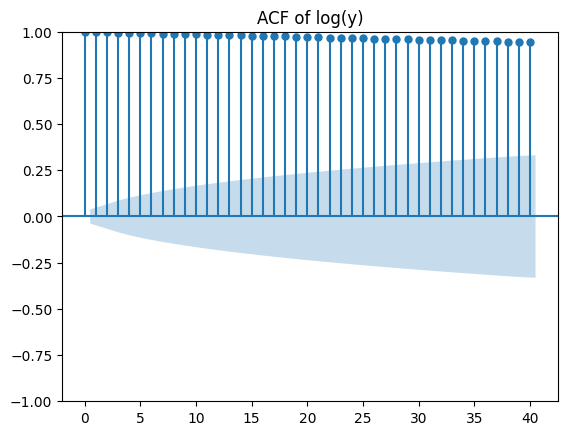

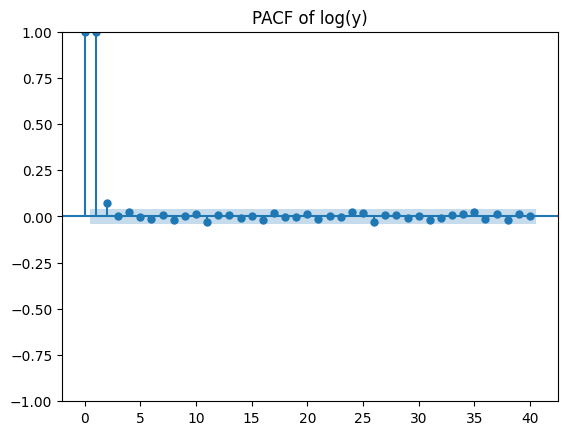

In [35]:
plot_acf(log_y.dropna(), lags=40)
plt.title("ACF of log(y)")
plt.show()

plot_pacf(log_y.dropna(), lags=40, method='ywm')
plt.title("PACF of log(y)")
plt.show()

Both tests agree the log-transformed series is still non-stationary.
The log transform stabilizes variance (i.e., reduces exponential growth), but not mean. So, differencing is still needed.

ACF:

High correlations close to 1 for many lags, only slowly declining → strong persistence, typical of non-stationary or trend-dominated series.

PACF:

The first two lags are near 1, after which correlations drop sharply and lie within the confidence bounds.

This pattern indicates that the non-stationarity is largely due to a trend (not seasonal) component, which can usually be removed by first differencing.


log fd

In [36]:
log_y = np.log(series)
log_fd = log_y.diff().dropna()


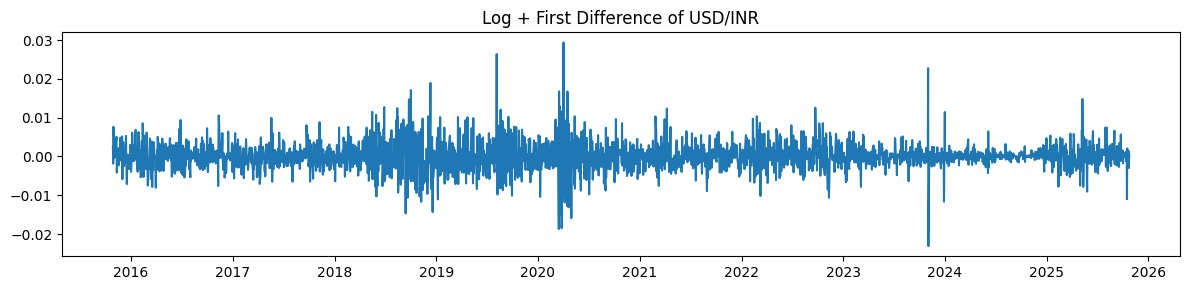

In [37]:
plt.figure(figsize=(12,3))
plt.plot(log_fd)
plt.title("Log + First Difference of USD/INR")
plt.tight_layout()
plt.show()


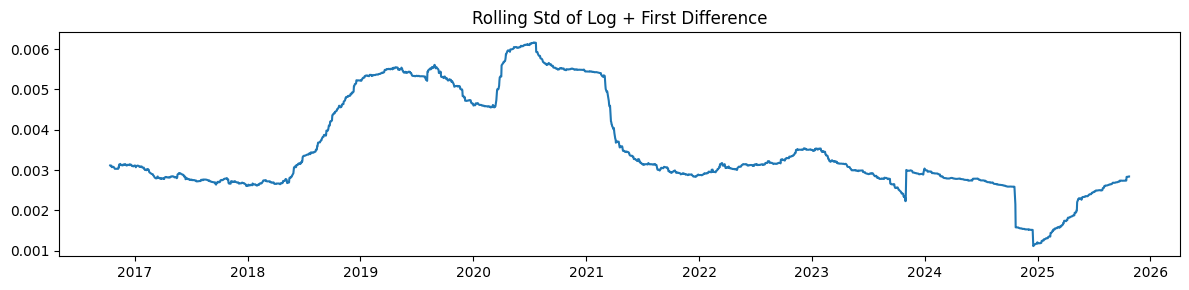

In [ ]:
#rolling std to check variance stability
roll_std = log_fd.rolling(window=252).std()
plt.figure(figsize=(12,3))
plt.plot(roll_std)
plt.title("Rolling Std of Log + First Difference")
plt.tight_layout()
plt.show()


In [ ]:


#adf test after log fd
def adf_test(x):
    res = adfuller(x.dropna(), autolag='AIC')
    return res[0], res[1], res[4]

def kpss_test(x):
    res = kpss(x.dropna(), regression='c', nlags='auto')
    return res[0], res[1], res[3]

adf_stat, adf_p, adf_crit = adf_test(log_fd)
kpss_stat, kpss_p, kpss_crit = kpss_test(log_fd)

print(f"ADF stat (log + first diff): {adf_stat:.4f}, p={adf_p:.4f}")
print(f"KPSS stat (log + first diff): {kpss_stat:.4f}, p={kpss_p:.4f}")
print("ADF critical values:", adf_crit)
print("KPSS critical values:", kpss_crit)
adf_stat, adf_p, adf_crit = adf_test(log_fd)
kpss_stat, kpss_p, kpss_crit = kpss_test(log_fd)


ADF stat (log + first diff): -15.5560, p=0.0000
KPSS stat (log + first diff): 0.0398, p=0.1000
ADF critical values: {'1%': np.float64(-3.4328695430687004), '5%': np.float64(-2.8626531392022194), '10%': np.float64(-2.5673625639785684)}
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


here p val is <0.05  stating that it is stationaryy

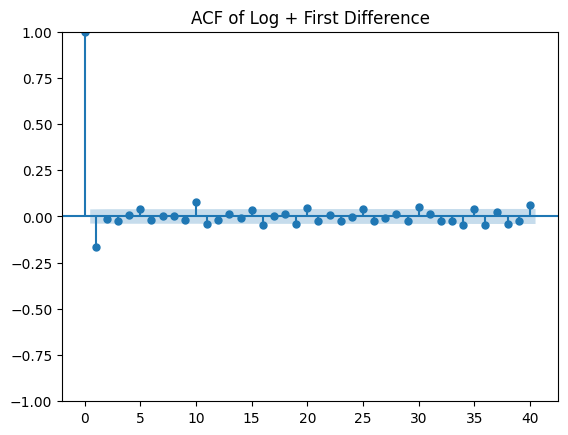

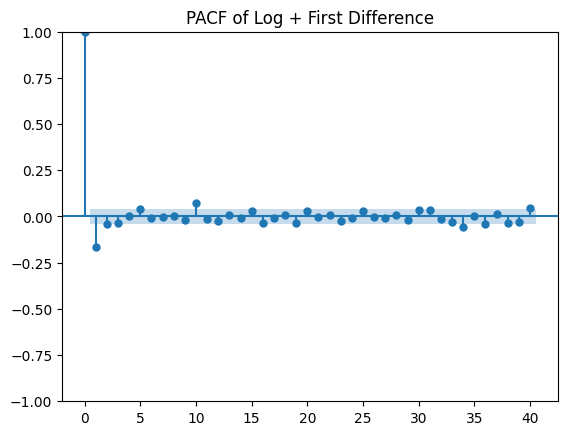

In [ ]:
#ACF / PACF 
plot_acf(log_fd, lags=40)
plt.title("ACF of Log + First Difference")
plt.show()

plot_pacf(log_fd, lags=40, method='ywm')
plt.title("PACF of Log + First Difference")
plt.show()

In [51]:
df

Close  daily_diff
Date                             
2015-10-27  64.901001         NaN
2015-10-28  65.067001   64.901001
2015-10-29  64.945999   65.067001
2015-10-30  65.444000   64.945999
2015-11-02  65.415001   65.444000
...               ...         ...
2025-10-20  88.002296   87.990700
2025-10-21  87.879997   88.002296
2025-10-22  88.001602   87.879997
2025-10-23  87.740303   88.001602
2025-10-24  87.778999   87.740303

[2603 rows x 2 columns]

seasonality +seasonality decomposition

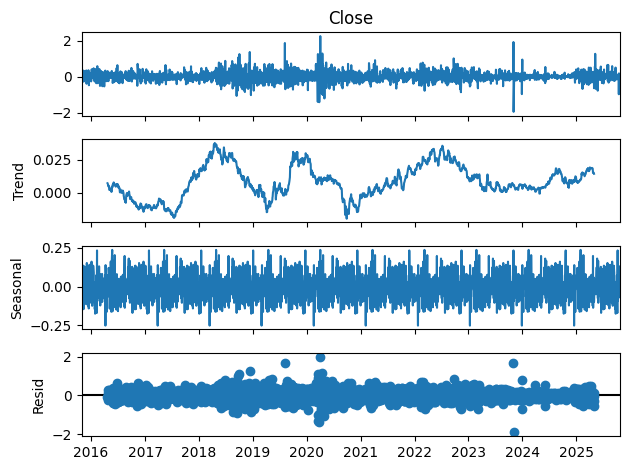

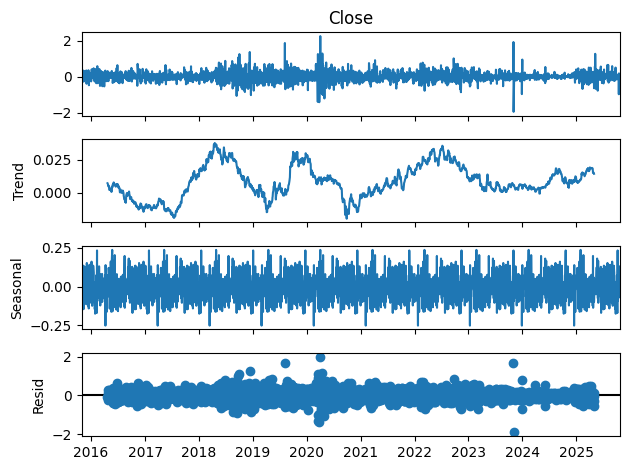

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(fd.dropna(), model='additive', period=252)  # yearly seasonality
decomp.plot()


seasonality for log_fd

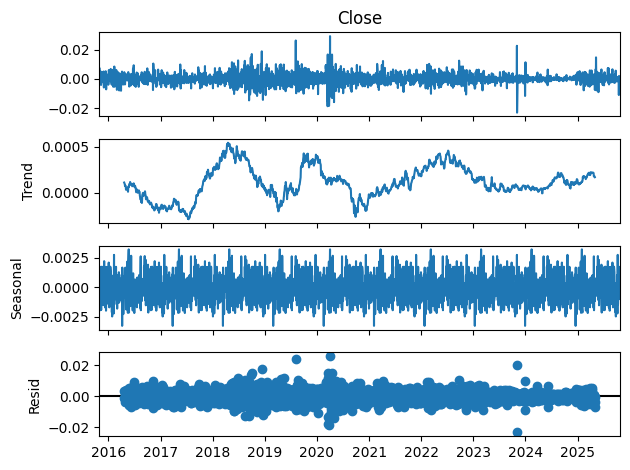

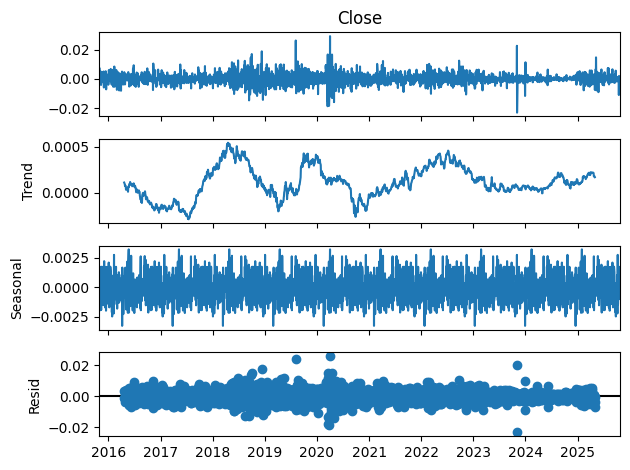

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp1 = seasonal_decompose(log_fd.dropna(), model='additive', period=252)  # yearly seasonality
decomp1.plot()


In [18]:
from statsmodels.tsa.arima.model import ARIMA

best_aic = float("inf")
best_order = None
for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = ARIMA(y_log, order=(p,1,q))
            res = model.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,1,q)
        except:
            continue

print("Best ARIMA order:", best_order, "with AIC:", best_aic)


Best ARIMA order: (0, 1, 1) with AIC: -21866.083976004942


In [15]:
seasonal_periods = [252, 52, 5]  # trading-year, weekly, work-week; adjust if necessary

for m in seasonal_periods:
    # skip if series shorter than 2*m
    if len(series) < 2*m:
        print(f"Skipping period {m} (series too short)")
        continue
    sdiff = series_log.diff(m).dropna()
    print(f"\nStationarity after seasonal diff (m={m}):")
    print_stationarity(sdiff, f"log seasonal diff (lag={m})")
    # also seasonal + first diff
    sdiff2 = sdiff.diff().dropna()
    print(f"Stationarity after seasonal diff + first diff (m={m}):")
    print_stationarity(sdiff2, f"log seasonal diff + first diff (lag={m})")



Stationarity after seasonal diff (m=252):

Stationarity tests for log seasonal diff (lag=252):
  ADF stat = -2.4866, p = 0.1188  (H0: non-stationary)
  KPSS stat= 0.5964, p = 0.0230  (H0: stationary)
Stationarity after seasonal diff + first diff (m=252):

Stationarity tests for log seasonal diff + first diff (lag=252):
  ADF stat = -15.3915, p = 0.0000  (H0: non-stationary)
  KPSS stat= 0.0388, p = 0.1000  (H0: stationary)

Stationarity after seasonal diff (m=52):

Stationarity tests for log seasonal diff (lag=52):
  ADF stat = -6.1130, p = 0.0000  (H0: non-stationary)
  KPSS stat= 0.1485, p = 0.1000  (H0: stationary)
Stationarity after seasonal diff + first diff (m=52):

Stationarity tests for log seasonal diff + first diff (lag=52):
  ADF stat = -14.7818, p = 0.0000  (H0: non-stationary)
  KPSS stat= 0.0109, p = 0.1000  (H0: stationary)

Stationarity after seasonal diff (m=5):

Stationarity tests for log seasonal diff (lag=5):
  ADF stat = -8.8892, p = 0.0000  (H0: non-stationary)
 

In [98]:
# --- Stationarity tests ------------------------------------------------------
def adf_test(x, signif=0.05):
    res = adfuller(x, autolag='AIC')
    out = {
        "ADF Statistic": res[0],
        "p-value": res[1],
        "Used lags": res[2],
        "nobs": res[3],
        "Critical Values": res[4]
    }
    print(">>> ADF test")
    for k,v in out.items():
        print(f"{k}: {v}")
    if res[1] < signif:
        print("=> Reject H0 (series is likely stationary)")
    else:
        print("=> Fail to reject H0 (series is likely non-stationary)")
    print()

def kpss_test(x, signif=0.05, regression='c'):
    res = kpss(x, regression=regression, nlags="auto")
    out = {
        "KPSS Statistic": res[0],
        "p-value": res[1],
        "Used lags": res[2],
        "Critical Values": res[3]
    }
    print(">>> KPSS test (null: stationary)")
    for k,v in out.items():
        print(f"{k}: {v}")
    if res[1] < signif:
        print("=> Reject H0 (series is likely non-stationary)")
    else:
        print("=> Fail to reject H0 (series is likely stationary)")
    print()

print("Stationarity tests on original series:")
adf_test(series.dropna())
kpss_test(series.dropna())

Stationarity tests on original series:
>>> ADF test
ADF Statistic: -0.21552355440596138
p-value: 0.93664577733955
Used lags: 10
nobs: 2592
Critical Values: {'1%': np.float64(-3.4328753811355464), '5%': np.float64(-2.862655717379379), '10%': np.float64(-2.567363936620037)}
=> Fail to reject H0 (series is likely non-stationary)

>>> KPSS test (null: stationary)
KPSS Statistic: 8.027952463864885
p-value: 0.01
Used lags: 30
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Reject H0 (series is likely non-stationary)



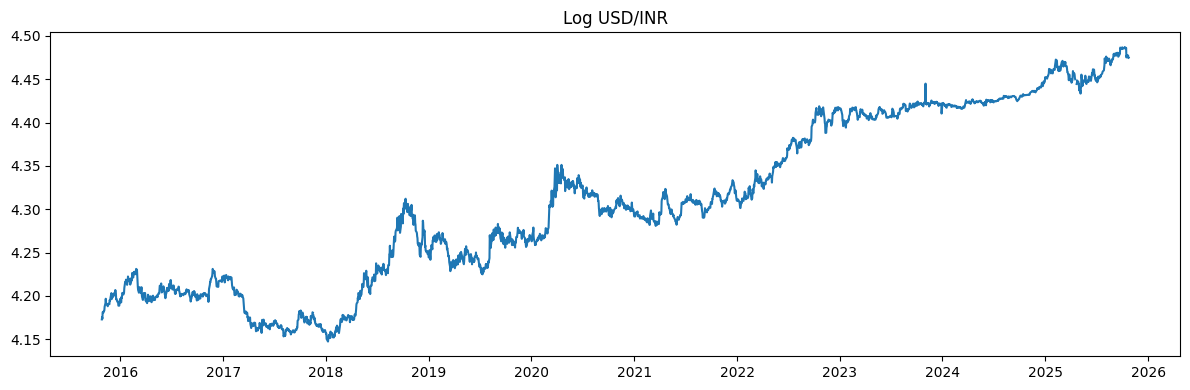

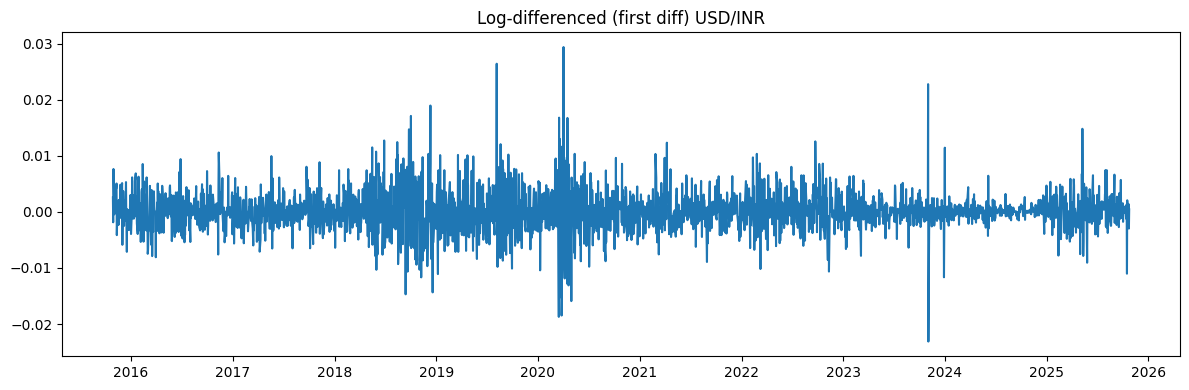

Stationarity tests on log-differenced series:
>>> ADF test
ADF Statistic: -15.529016031999653
p-value: 2.2329358018192206e-28
Used lags: 9
nobs: 2587
Critical Values: {'1%': np.float64(-3.4328802668982084), '5%': np.float64(-2.862657875000973), '10%': np.float64(-2.5673650853551155)}
=> Reject H0 (series is likely stationary)

>>> KPSS test (null: stationary)
KPSS Statistic: 0.0396463582028881
p-value: 0.1
Used lags: 3
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> Fail to reject H0 (series is likely stationary)



In [99]:
# If non-stationary, common steps: log transform, first difference
series_log = np.log(series)
plt.figure(figsize=(12,4))
plt.plot(series_log)
plt.title("Log USD/INR")
plt.tight_layout()
plt.show()

# Difference once
series_log_diff = series_log.diff().dropna()
plt.figure(figsize=(12,4))
plt.plot(series_log_diff)
plt.title("Log-differenced (first diff) USD/INR")
plt.tight_layout()
plt.show()

print("Stationarity tests on log-differenced series:")
adf_test(series_log_diff)
kpss_test(series_log_diff)

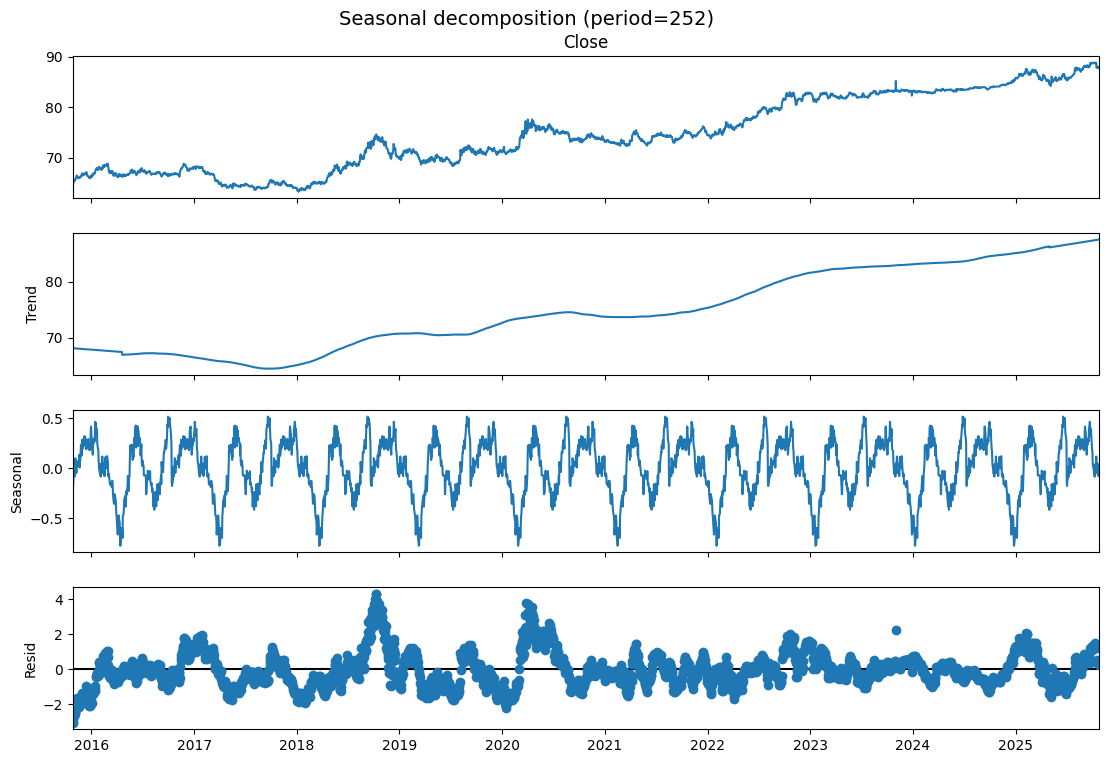

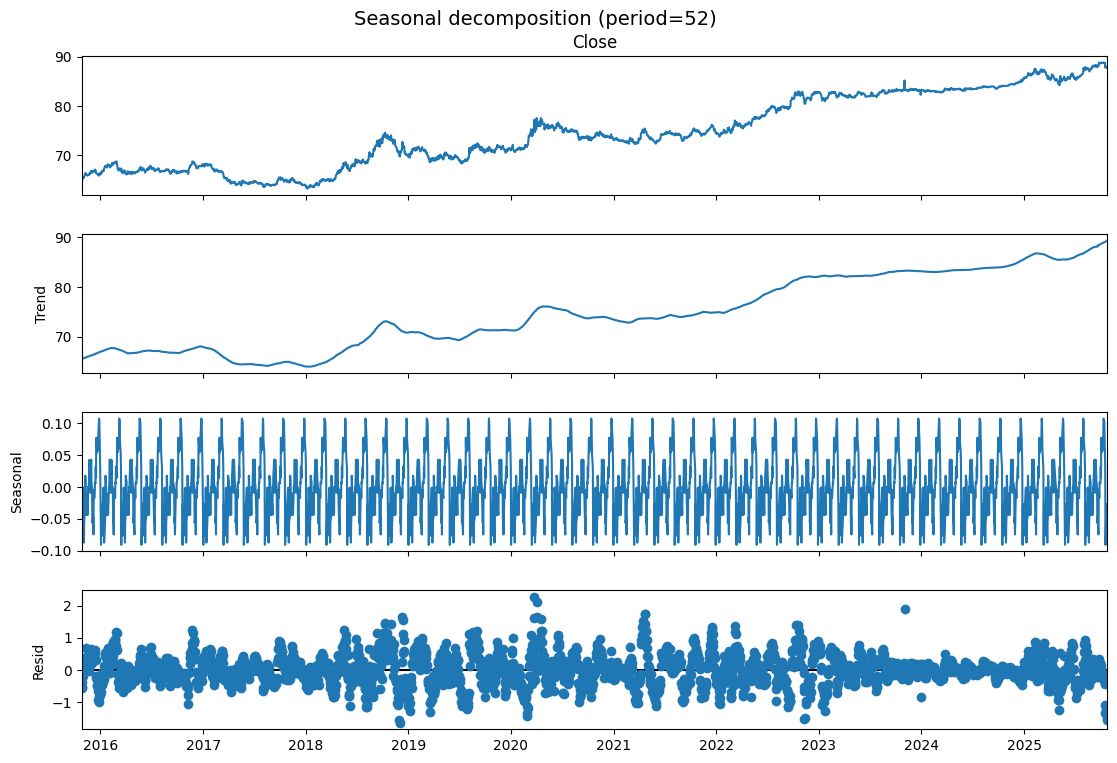

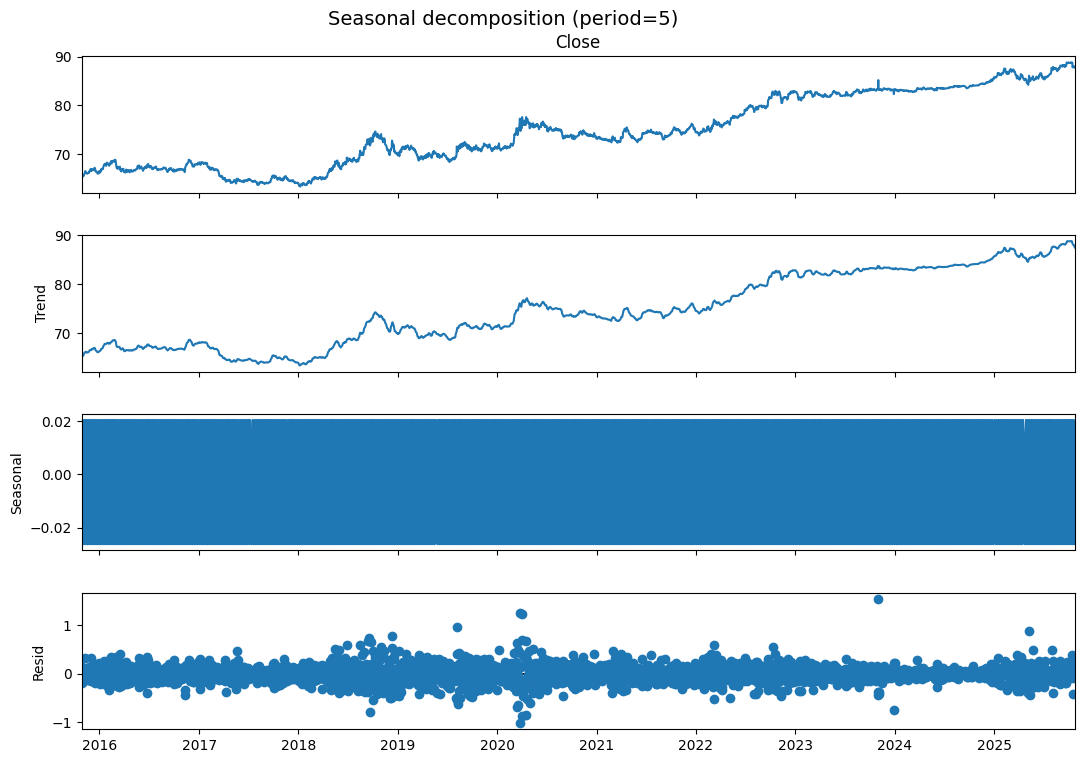

In [101]:
# Seasonal decompose requires a period. Try both period=252 (annual trading days) and 52 (weekly)
for period in [252, 52, 5]:  # 5 for weekly seasonality inside each week (if using daily)
    try:
        dec = seasonal_decompose(series.dropna(), period=period, model='additive', extrapolate_trend='freq')
        fig = dec.plot()
        fig.suptitle(f"Seasonal decomposition (period={period})", fontsize=14)
        fig.set_size_inches(12,8)
        plt.show()
    except Exception as e:
        print(f"Decompose period={period} failed: {e}")

<Figure size 1200x400 with 0 Axes>

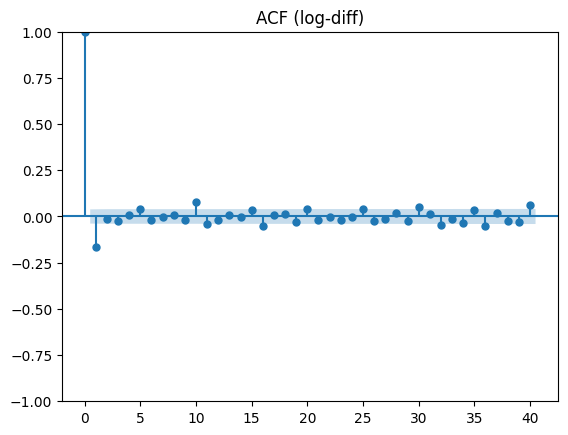

<Figure size 1200x400 with 0 Axes>

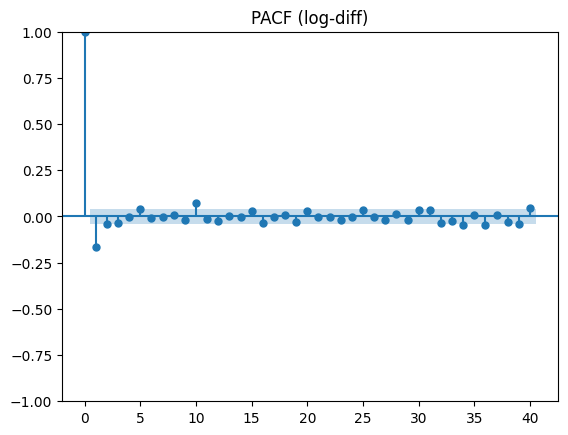

In [102]:
data_for_acf = series_log_diff  # choose best transformed series from tests above

plt.figure(figsize=(12,4))
plot_acf(data_for_acf.dropna(), lags=40, alpha=0.05)
plt.title("ACF (log-diff)")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(data_for_acf.dropna(), lags=40, method='ywm', alpha=0.05)
plt.title("PACF (log-diff)")
plt.show()
